# Atlas 14 Multi-Project

In [1]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

#Import the ras-commander package
from ras_commander import *

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

```python
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *
```

# Atlas 14 Uncertainty Analysis with Multi-Project Support

This notebook performs comprehensive uncertainty analysis of precipitation-driven flooding by:

1. **Processing Multiple Durations**: Analyzes 1-hr, 2-hr, 3-hr, 6-hr, 12-hr, 24-hr, and 2-day storms
2. **Including Confidence Intervals**: Runs upper and lower confidence bounds for each scenario
3. **Quantifying Uncertainty**: Shows how precipitation uncertainty propagates through flood models
4. **Comprehensive Visualization**: Creates confidence envelope plots and uncertainty heatmaps
5. **Multi-Project Management**: Automatically handles HEC-RAS 99-plan limit by distributing scenarios across multiple project copies

## Methodology

**Confidence Interval Estimation:**
- NOAA Atlas 14 precipitation estimates have inherent uncertainty
- Upper confidence bound ≈ 1.4 × point estimate
- Lower confidence bound ≈ 0.7 × point estimate
- These factors represent approximate 90% confidence intervals

**Scenario Matrix:**
- 6 AEP events (2, 5, 10, 25, 50, 100 years)
- 7 durations (1hr, 2hr, 3hr, 6hr, 12hr, 24hr, 2day)
- 3 confidence levels (lower, point, upper)
- **Total: 126 scenarios**

**99-Plan Limit Solution:**
- HEC-RAS projects limited to 99 plans maximum
- Automated distribution across multiple project copies
- Preserves original project (all work done in copies)
- Results automatically aggregated from all projects

**Analysis Outputs:**
- Confidence envelopes for peak water surfaces
- Uncertainty quantification by duration and location
- Design recommendations considering uncertainty

## Setup and Import Libraries

In [2]:
!pip install seaborn

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from pathlib import Path
from datetime import datetime, timedelta
from IPython import display
import psutil
from itertools import product

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## Extract and Initialize Project

In [4]:
import os
import sys
current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent
sys.path.append(str(rascmdr_directory))
print("Loading ras-commander from local dev copy")

# Import RAS-Commander modules
from ras_commander import *

Loading ras-commander from local dev copy


In [5]:
# Initialize project
current_dir = Path.cwd()
pipes_ex_path = current_dir / "A14_Examples" / "Davis"
rasexamples_extract_path = current_dir / "A14_Examples"

if not pipes_ex_path.exists():
    RasExamples.extract_project(["Davis"], output_path="example_projects_104_Atlas14_AEP_Multi_Project")

init_ras_project(pipes_ex_path, "6.6")
print(f"Initialized HEC-RAS project: {ras.project_name}")
print(f"\nBase plan configuration:")
display.display(ras.plan_df)

2025-11-18 06:21:26 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis\DavisStormSystem.rasmap


Initialized HEC-RAS project: DavisStormSystem

Base plan configuration:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,None,02,C:\GH\ras-commander\examples\A14_Examples\Davi...,01,C:\GH\ras-commander\examples\A14_Examples\Davi...,C:\GH\ras-commander\examples\A14_Examples\Davi...,Unsteady


## Enhanced Hyetograph Generation with Confidence Intervals

These functions extend the original hyetograph generation to support:
- Multiple durations (not just 24-hour)
- Confidence interval calculations
- Systematic scenario organization

In [6]:
def parse_duration(duration_str):
    """
    Parses a duration string and converts it to hours.
    Examples: "5-min:" -> 0.0833 hours, "2-hr:" -> 2 hours, "2-day:" -> 48 hours
    """
    match = re.match(r'(\d+)-(\w+):', duration_str.strip())
    if not match:
        raise ValueError(f"Invalid duration format: {duration_str}")
    value, unit = match.groups()
    value = int(value)
    unit = unit.lower()
    if unit in ['min', 'minute', 'minutes']:
        hours = value / 60.0
    elif unit in ['hr', 'hour', 'hours']:
        hours = value
    elif unit in ['day', 'days']:
        hours = value * 24
    else:
        raise ValueError(f"Unknown time unit in duration: {unit}")
    return hours

def read_precipitation_data(csv_file):
    """
    Reads the precipitation frequency CSV and returns a DataFrame
    with durations in hours as the index and ARIs as columns.
    """
    with open(csv_file, 'r') as f:
        lines = f.readlines()

    header_line_idx = None
    header_pattern = re.compile(r'^by duration for ari', re.IGNORECASE)

    # Locate the header line
    for idx, line in enumerate(lines):
        if header_pattern.match(line.strip().lower()):
            header_line_idx = idx
            break

    if header_line_idx is None:
        raise ValueError('Header line for precipitation frequency estimates not found in CSV file.')

    # Extract the ARI headers from the header line
    header_line = lines[header_line_idx].strip()
    headers = [item.strip() for item in header_line.split(',')]
    
    if len(headers) < 2:
        raise ValueError('Insufficient number of ARI columns found in the header line.')

    aris = headers[1:]  # Exclude the first column which is the duration

    # Define the pattern for data lines
    duration_pattern = re.compile(r'^\d+-(min|hr|day):')

    # Initialize lists to store durations and corresponding depths
    durations = []
    depths = {ari: [] for ari in aris}

    # Iterate over the lines following the header to extract data
    for line in lines[header_line_idx + 1:]:
        line = line.strip()
        if not line:
            continue
        if not duration_pattern.match(line):
            break
        parts = [part.strip() for part in line.split(',')]
        if len(parts) != len(headers):
            raise ValueError(f"Data row does not match header columns: {line}")
        duration_str = parts[0]
        
        # Parse duration with clear error message if it fails
        duration_hours = parse_duration(duration_str)  # Let ValueError propagate
        
        durations.append(duration_hours)
        for ari, depth_str in zip(aris, parts[1:]):
            # Convert depth, using NaN for empty/missing values
            if depth_str.strip() == '' or depth_str.strip().lower() == 'nan':
                depth = np.nan
            else:
                depth = float(depth_str)  # Let ValueError propagate for malformed data
            depths[ari].append(depth)

    # Create the DataFrame
    df = pd.DataFrame(depths, index=durations)
    df.index.name = 'Duration_hours'
    df = df.dropna()

    return df

def create_confidence_intervals(df_point, upper_factor=1.4, lower_factor=0.7):
    """
    Creates upper and lower confidence interval DataFrames from point estimates.
    
    Parameters:
    - df_point: DataFrame with point estimates
    - upper_factor: Multiplier for upper CI (default 1.4 for ~90% CI)
    - lower_factor: Multiplier for lower CI (default 0.7 for ~90% CI)
    
    Returns:
    - Tuple of (df_lower, df_point, df_upper)
    """
    df_upper = df_point * upper_factor
    df_lower = df_point * lower_factor
    
    return df_lower, df_point, df_upper

def get_time_interval(duration_hrs):
    """
    Determines the appropriate time interval based on storm duration.
    
    Parameters:
    -----------
    duration_hrs : float
        Storm duration in hours
    
    Returns:
    --------
    float : Time interval in hours
    """
    if duration_hrs >= 24:
        return 1.0  # 1 hour for 24+ hour storms
    elif duration_hrs >= 12:
        return 0.5  # 30 minutes for 12-hour storms
    elif duration_hrs >= 6:
        return 0.25  # 15 minutes for 6-hour storms
    else:
        return 5.0 / 60.0  # 5 minutes for storms less than 6 hours

def interpolate_depths(df, total_duration):
    """
    Interpolates precipitation depths for each ARI on a log-log scale
    using appropriate time intervals based on duration.
    
    Parameters:
    -----------
    df : DataFrame
        Precipitation frequency data with durations as index and ARIs as columns
    total_duration : float
        Total storm duration in hours
    
    Returns:
    --------
    tuple : (dict of interpolated depths, time array in hours)
    """
    # Determine time interval based on duration
    dt = get_time_interval(total_duration)
    
    # Create time array with appropriate interval
    t_hours = np.arange(dt, total_duration + dt/2, dt)
    
    D = {}
    for ari in df.columns:
        durations = df.index.values
        depths = df[ari].values
        if np.any(depths <= 0):
            raise ValueError(f"Non-positive depth value in ARI {ari}")
        
        # Log-log interpolation
        log_durations = np.log(durations)
        log_depths = np.log(depths)
        log_t = np.log(t_hours)
        log_D_t = np.interp(log_t, log_durations, log_depths)
        D_t = np.exp(log_D_t)
        D[ari] = D_t
    
    return D, t_hours

def compute_incremental_depths(D, t_hours):
    """
    Computes incremental precipitation depths for each time interval.
    I(t) = D(t) - D(t-1), with D(0) = 0.
    
    Parameters:
    -----------
    D : dict
        Dictionary of cumulative depths for each ARI
    t_hours : array
        Time array in hours
    
    Returns:
    --------
    dict : Dictionary of incremental depths for each ARI
    """
    incremental_depths = {}
    for ari, D_t in D.items():
        num_intervals = len(t_hours)
        I_t = np.empty(num_intervals)
        I_t[0] = D_t[0]
        I_t[1:] = D_t[1:] - D_t[:-1]
        incremental_depths[ari] = I_t
    return incremental_depths

def assign_alternating_block(sorted_depths, max_depth, central_index, num_intervals):
    """
    Assigns incremental depths to the hyetograph using the Alternating Block Method.
    
    Parameters:
    -----------
    sorted_depths : list
        Sorted incremental depths (descending)
    max_depth : float
        Maximum depth value
    central_index : int
        Index for peak position
    num_intervals : int
        Total number of time intervals
    
    Returns:
    --------
    list : Hyetograph array
    """
    hyetograph = [0.0] * num_intervals
    hyetograph[central_index] = max_depth
    remaining_depths = sorted_depths.copy()
    remaining_depths.remove(max_depth)
    left = central_index - 1
    right = central_index + 1
    toggle = True
    for depth in remaining_depths:
        if toggle and right < num_intervals:
            hyetograph[right] = depth
            right += 1
        elif not toggle and left >= 0:
            hyetograph[left] = depth
            left -= 1
        elif right < num_intervals:
            hyetograph[right] = depth
            right += 1
        elif left >= 0:
            hyetograph[left] = depth
            left -= 1
        else:
            print("Warning: Not all incremental depths assigned.")
            break
        toggle = not toggle
    return hyetograph

def generate_hyetograph(incremental_depths, position_percent, num_intervals):
    """
    Generates the hyetograph for a given ARI using the Alternating Block Method.
    
    Parameters:
    -----------
    incremental_depths : array
        Incremental depths for each time interval
    position_percent : float
        Peak position as percentage (e.g., 50 for middle)
    num_intervals : int
        Total number of time intervals
    
    Returns:
    --------
    list : Hyetograph array
    """
    max_depth = np.max(incremental_depths)
    incremental_depths_list = incremental_depths.tolist()
    central_index = int(round(num_intervals * position_percent / 100)) - 1
    central_index = max(0, min(central_index, num_intervals - 1))
    sorted_depths = sorted(incremental_depths_list, reverse=True)
    hyetograph = assign_alternating_block(sorted_depths, max_depth, central_index, num_intervals)
    return hyetograph

def save_hyetograph(hyetograph, t_hours, ari, duration_hrs, ci_level, output_dir, position_percent):
    """
    Saves the hyetograph to a CSV file with clear naming convention.
    
    Parameters:
    -----------
    hyetograph : array
        Hyetograph values
    t_hours : array
        Time array in hours
    ari : int or str
        Annual recurrence interval
    duration_hrs : float
        Storm duration in hours
    ci_level : str
        Confidence level ('lower', 'point', 'upper')
    output_dir : str
        Output directory path
    position_percent : float
        Peak position percentage
    
    Returns:
    --------
    str : Path to saved file
    """
    # Determine time interval
    dt = get_time_interval(duration_hrs)
    
    # Create DataFrame with appropriate time units
    if dt >= 1.0:
        time_col_name = 'Time_hour'
        time_values = t_hours
    elif dt >= 1.0/60.0:
        time_col_name = 'Time_min'
        time_values = t_hours * 60  # Convert to minutes
    else:
        time_col_name = 'Time_hour'
        time_values = t_hours
    
    df = pd.DataFrame({
        time_col_name: time_values,
        'Precipitation_in': hyetograph
    })
    
    # Format duration string
    if duration_hrs >= 24:
        dur_str = f"{int(duration_hrs/24)}day"
    else:
        dur_str = f"{int(duration_hrs)}hr"
    
    filename = f'hyetograph_ARI_{ari}_DUR_{dur_str}_CI_{ci_level}.csv'
    output_file = os.path.join(output_dir, filename)
    
    # Add metadata as header comment
    with open(output_file, 'w') as f:
        f.write(f"# NOAA Atlas 14 Hyetograph\n")
        f.write(f"# ARI: {ari} years\n")
        f.write(f"# Duration: {duration_hrs} hours\n")
        f.write(f"# Time Interval: {dt*60:.1f} minutes\n")
        f.write(f"# Confidence Level: {ci_level}\n")
        f.write(f"# Peak Position: {position_percent}%\n")
        f.write(f"# Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        df.to_csv(f, index=False)
    
    return output_file

print("Hyetograph generation functions defined (with variable time intervals)")

Hyetograph generation functions defined (with variable time intervals)


## Generate Complete Scenario Matrix

Create hyetographs for all combinations of:
- AEP events: 2, 5, 10, 25, 50, 100 years
- Durations: 1hr, 2hr, 3hr, 6hr, 12hr, 24hr, 2day
- Confidence levels: lower, point, upper

In [7]:
# Configuration
input_csv = 'data/PF_Depth_English_PDS_DavisCA.csv'
output_dir = 'hyetographs_uncertainty'
position_percent = 50
base_plan = "02"

# Define scenario parameters
aep_events = [2, 5, 10, 25, 50, 100]
durations = [1, 2, 3, 6, 12, 24, 48]  # hours
ci_levels = ['lower', 'point', 'upper']
ci_factors = {'lower': 0.7, 'point': 1.0, 'upper': 1.4}

# Create output directory
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir}")
print(f"\nScenario Matrix:")
print(f"  AEP Events: {aep_events}")
print(f"  Durations: {durations} hours")
print(f"  CI Levels: {ci_levels}")
print(f"  Total Scenarios: {len(aep_events) * len(durations) * len(ci_levels)}")

Output directory: hyetographs_uncertainty

Scenario Matrix:
  AEP Events: [2, 5, 10, 25, 50, 100]
  Durations: [1, 2, 3, 6, 12, 24, 48] hours
  CI Levels: ['lower', 'point', 'upper']
  Total Scenarios: 126


In [8]:
# Read precipitation data
print("Reading NOAA Atlas 14 data...")
df_point = read_precipitation_data(input_csv)
print(f"Successfully read data with {len(df_point)} durations and {len(df_point.columns)} ARI values")

# Display the data
print("\nPrecipitation Frequency Data (Point Estimates):")
display.display(df_point.head(10))

# Create confidence interval DataFrames
print("\nGenerating confidence intervals...")
df_lower, df_point, df_upper = create_confidence_intervals(df_point)
print("Confidence intervals created:")
print(f"  Lower CI factor: {ci_factors['lower']}")
print(f"  Point estimate factor: {ci_factors['point']}")
print(f"  Upper CI factor: {ci_factors['upper']}")

Reading NOAA Atlas 14 data...
Successfully read data with 19 durations and 10 ARI values

Precipitation Frequency Data (Point Estimates):


,1,2,5,10,25,50,100,200,500,1000
Duration_hours,,,,,,,,,,
0.083333,0.112,0.137,0.174,0.207,0.257,0.299,0.347,0.400,0.479,0.548
0.166667,0.161,0.197,0.250,0.297,0.368,0.429,0.497,0.573,0.687,0.785
0.250000,0.194,0.238,0.302,0.359,0.446,0.519,0.601,0.693,0.830,0.949
0.500000,0.297,0.364,0.461,0.548,0.680,0.792,0.917,1.060,1.270,1.450
1.000000,0.387,0.474,0.601,0.714,0.886,1.030,1.200,1.380,1.650,1.890
2.000000,0.565,0.696,0.880,1.040,1.270,1.470,1.670,1.900,2.230,2.500
3.000000,0.698,0.861,1.090,1.280,1.560,1.790,2.030,2.290,2.660,2.960
6.000000,1.000,1.240,1.570,1.840,2.220,2.530,2.850,3.190,3.660,4.040
12.000000,1.340,1.680,2.130,2.500,3.010,3.410,3.830,4.260,4.860,5.330



Generating confidence intervals...
Confidence intervals created:
  Lower CI factor: 0.7
  Point estimate factor: 1.0
  Upper CI factor: 1.4


In [9]:
# Generate all hyetographs
print("Generating hyetographs with variable time intervals...\n")
print("Time Interval Rules:")
print("  • 24+ hour storms: 1-hour intervals")
print("  • 12-hour storms: 30-minute intervals")
print("  • 6-hour storms: 15-minute intervals")
print("  • < 6-hour storms: 5-minute intervals\n")

scenario_list = []
hyetograph_count = 0

for ari in aep_events:
    ari_str = str(ari)
    
    # Check if this ARI is in the data
    if ari_str not in df_point.columns:
        print(f"Warning: ARI {ari_str} not found in data. Skipping.")
        continue
    
    for duration in durations:
        # Get time interval for this duration
        dt = get_time_interval(duration)
        print(f"Processing {ari}-yr, {duration}-hr storm (dt={dt*60:.1f} min)...")
        
        # Process each confidence level
        for ci_level in ci_levels:
            # Select the appropriate DataFrame
            if ci_level == 'lower':
                df_current = df_lower
            elif ci_level == 'upper':
                df_current = df_upper
            else:
                df_current = df_point
            
            # Interpolate depths with appropriate time interval
            D, t_hours = interpolate_depths(df_current, duration)
            
            # Compute incremental depths
            inc_depths = compute_incremental_depths(D, t_hours)
            
            # Generate hyetograph
            num_intervals = len(t_hours)
            hyetograph = generate_hyetograph(inc_depths[ari_str], position_percent, num_intervals)
            
            # Save hyetograph
            file_path = save_hyetograph(hyetograph, t_hours, ari_str, duration, ci_level, 
                                       output_dir, position_percent)
            
            # Record scenario
            scenario_list.append({
                'ari': ari,
                'duration_hrs': duration,
                'time_interval_min': dt * 60,
                'num_intervals': num_intervals,
                'ci_level': ci_level,
                'hyetograph_file': file_path,
                'total_depth_in': sum(hyetograph)
            })
            
            hyetograph_count += 1

# Create scenario DataFrame
scenario_df = pd.DataFrame(scenario_list)

print(f"\n✓ Generated {hyetograph_count} hyetographs")
print(f"\nScenario Summary (first 12 rows):")
display.display(scenario_df.head(12))

# Save scenario list
scenario_csv = 'scenarios_uncertainty.csv'
scenario_df.to_csv(scenario_csv, index=False)
print(f"\nScenario list saved to: {scenario_csv}")

Generating hyetographs with variable time intervals...

Time Interval Rules:
  • 24+ hour storms: 1-hour intervals
  • 12-hour storms: 30-minute intervals
  • 6-hour storms: 15-minute intervals
  • < 6-hour storms: 5-minute intervals

Processing 2-yr, 1-hr storm (dt=5.0 min)...
Processing 2-yr, 2-hr storm (dt=5.0 min)...
Processing 2-yr, 3-hr storm (dt=5.0 min)...
Processing 2-yr, 6-hr storm (dt=15.0 min)...
Processing 2-yr, 12-hr storm (dt=30.0 min)...
Processing 2-yr, 24-hr storm (dt=60.0 min)...
Processing 2-yr, 48-hr storm (dt=60.0 min)...
Processing 5-yr, 1-hr storm (dt=5.0 min)...
Processing 5-yr, 2-hr storm (dt=5.0 min)...
Processing 5-yr, 3-hr storm (dt=5.0 min)...
Processing 5-yr, 6-hr storm (dt=15.0 min)...
Processing 5-yr, 12-hr storm (dt=30.0 min)...
Processing 5-yr, 24-hr storm (dt=60.0 min)...
Processing 5-yr, 48-hr storm (dt=60.0 min)...
Processing 10-yr, 1-hr storm (dt=5.0 min)...
Processing 10-yr, 2-hr storm (dt=5.0 min)...
Processing 10-yr, 3-hr storm (dt=5.0 min)...


,ari,duration_hrs,time_interval_min,num_intervals,ci_level,hyetograph_file,total_depth_in
0,2,1,5.0,12,lower,hyetographs_uncertainty\hyetograph_ARI_2_DUR_1...,0.3318
1,2,1,5.0,12,point,hyetographs_uncertainty\hyetograph_ARI_2_DUR_1...,0.4740
2,2,1,5.0,12,upper,hyetographs_uncertainty\hyetograph_ARI_2_DUR_1...,0.6636
3,2,2,5.0,24,lower,hyetographs_uncertainty\hyetograph_ARI_2_DUR_2...,0.4872
4,2,2,5.0,24,point,hyetographs_uncertainty\hyetograph_ARI_2_DUR_2...,0.6960
5,2,2,5.0,24,upper,hyetographs_uncertainty\hyetograph_ARI_2_DUR_2...,0.9744
6,2,3,5.0,36,lower,hyetographs_uncertainty\hyetograph_ARI_2_DUR_3...,0.6027
7,2,3,5.0,36,point,hyetographs_uncertainty\hyetograph_ARI_2_DUR_3...,0.8610
8,2,3,5.0,36,upper,hyetographs_uncertainty\hyetograph_ARI_2_DUR_3...,1.2054
9,2,6,15.0,24,lower,hyetographs_uncertainty\hyetograph_ARI_2_DUR_6...,0.8680



Scenario list saved to: scenarios_uncertainty.csv


## Total Precipitation Depth Analysis

Visualize total precipitation depths across all scenarios with confidence intervals

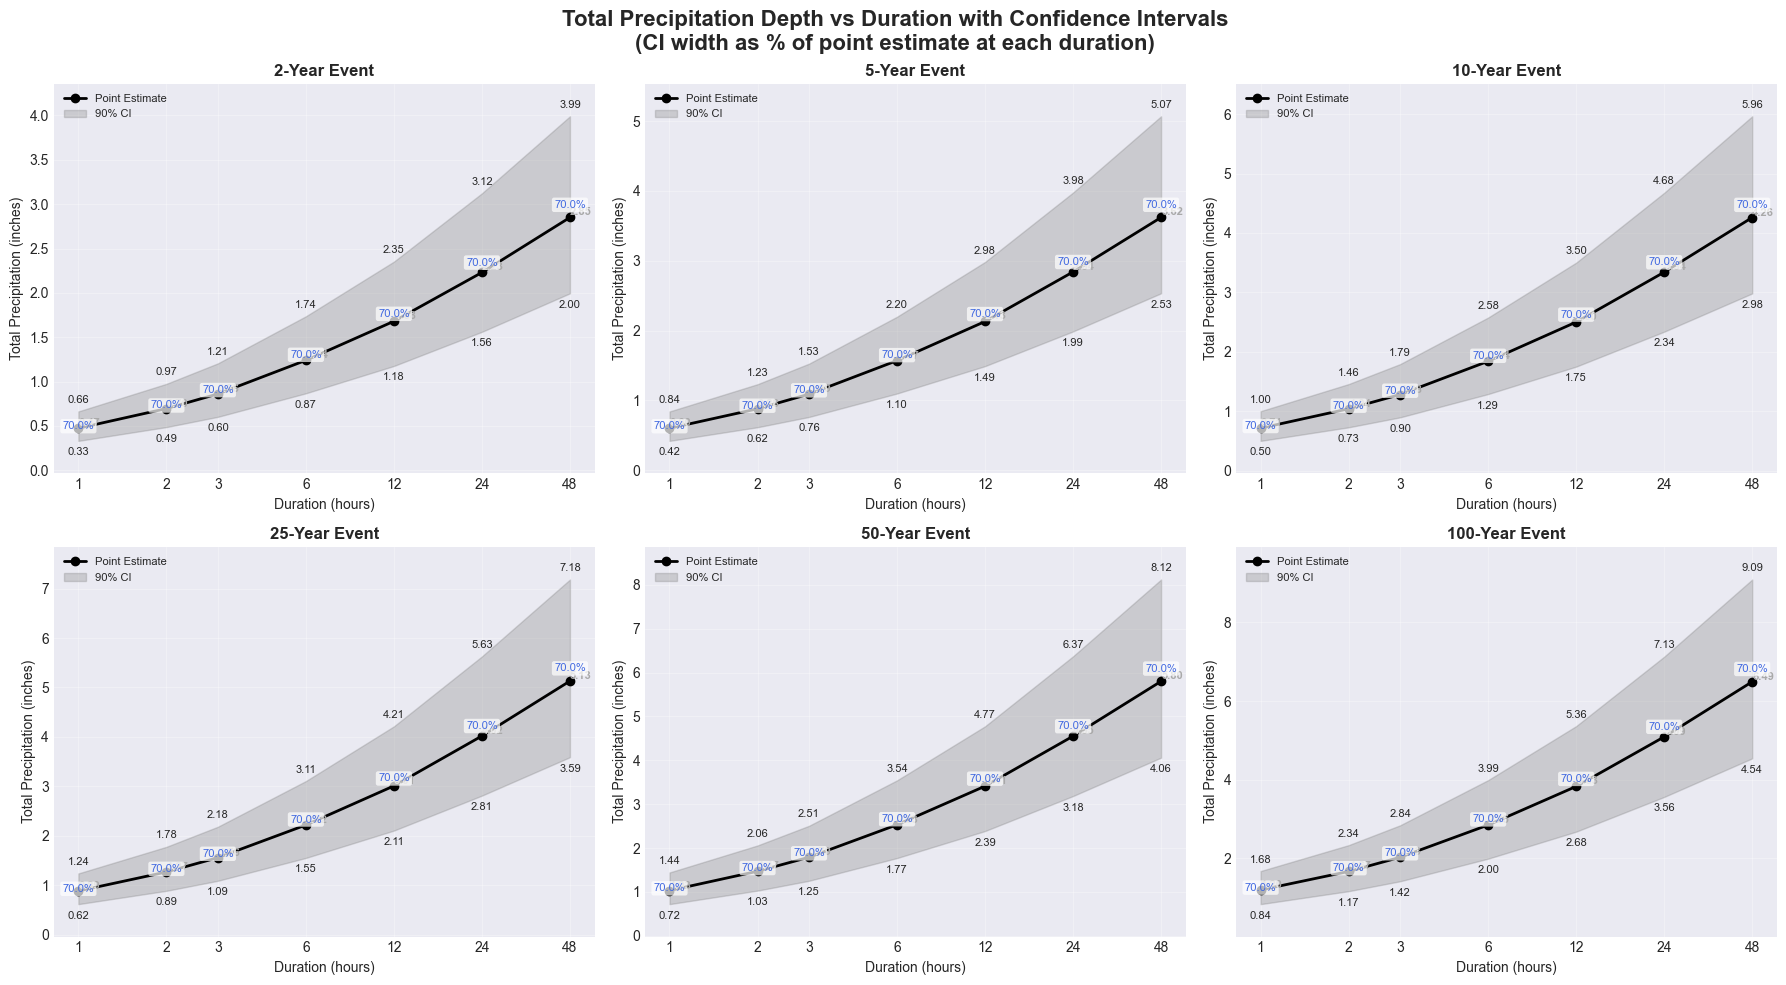


Confidence Interval Width as % of Point Estimate:

2-Year Event:
   1 hr: 70.0% (L:0.33, P:0.47, U:0.66)
   2 hr: 70.0% (L:0.49, P:0.70, U:0.97)
   3 hr: 70.0% (L:0.60, P:0.86, U:1.21)
   6 hr: 70.0% (L:0.87, P:1.24, U:1.74)
  12 hr: 70.0% (L:1.18, P:1.68, U:2.35)
  24 hr: 70.0% (L:1.56, P:2.23, U:3.12)
  48 hr: 70.0% (L:2.00, P:2.85, U:3.99)

5-Year Event:
   1 hr: 70.0% (L:0.42, P:0.60, U:0.84)
   2 hr: 70.0% (L:0.62, P:0.88, U:1.23)
   3 hr: 70.0% (L:0.76, P:1.09, U:1.53)
   6 hr: 70.0% (L:1.10, P:1.57, U:2.20)
  12 hr: 70.0% (L:1.49, P:2.13, U:2.98)
  24 hr: 70.0% (L:1.99, P:2.84, U:3.98)
  48 hr: 70.0% (L:2.53, P:3.62, U:5.07)

10-Year Event:
   1 hr: 70.0% (L:0.50, P:0.71, U:1.00)
   2 hr: 70.0% (L:0.73, P:1.04, U:1.46)
   3 hr: 70.0% (L:0.90, P:1.28, U:1.79)
   6 hr: 70.0% (L:1.29, P:1.84, U:2.58)
  12 hr: 70.0% (L:1.75, P:2.50, U:3.50)
  24 hr: 70.0% (L:2.34, P:3.34, U:4.68)
  48 hr: 70.0% (L:2.98, P:4.26, U:5.96)

25-Year Event:
   1 hr: 70.0% (L:0.62, P:0.89, U:1.24)
   2 hr

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is in scenario_df with columns: duration_hrs, ari, ci_level, total_depth_in

# Create the plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Define your ARI events (adjust based on your data)
aep_events = [2, 5, 10, 25, 50, 100]

for idx, ari in enumerate(aep_events):
    ax = axes[idx]

    # Extract data for this specific ARI
    ari_data = scenario_df[scenario_df['ari'] == ari].copy()

    # Get unique durations
    durations = sorted(ari_data['duration_hrs'].unique())

    # Initialize lists to store values
    lower_vals = []
    upper_vals = []
    point_vals = []
    ci_percentages = []

    # Process each duration
    for dur in durations:
        # Get data for this specific duration
        dur_data = ari_data[ari_data['duration_hrs'] == dur]

        # Extract values for each CI level
        lower_val = dur_data[dur_data['ci_level'] == 'lower']['total_depth_in'].values
        upper_val = dur_data[dur_data['ci_level'] == 'upper']['total_depth_in'].values
        point_val = dur_data[dur_data['ci_level'] == 'point']['total_depth_in'].values

        # Handle missing data
        if len(lower_val) > 0 and len(upper_val) > 0 and len(point_val) > 0:
            lower = float(lower_val[0])
            upper = float(upper_val[0])
            point = float(point_val[0])

            # Calculate CI width as percentage of point estimate
            # Using point estimate as the reference (you could also use mean of upper/lower)
            if point > 0:
                ci_width = upper - lower
                ci_pct = (ci_width / point) * 100
            else:
                ci_pct = np.nan
        else:
            lower = upper = point = ci_pct = np.nan

        lower_vals.append(lower)
        upper_vals.append(upper)
        point_vals.append(point)
        ci_percentages.append(ci_pct)

    # Convert to arrays
    lower_vals = np.array(lower_vals)
    upper_vals = np.array(upper_vals)
    point_vals = np.array(point_vals)
    ci_percentages = np.array(ci_percentages)

    # Plot the data
    ax.plot(durations, point_vals,
            'ko-', linewidth=2, markersize=6, label='Point Estimate')
    ax.fill_between(durations,
                    lower_vals,
                    upper_vals,
                    alpha=0.3, color='gray', label='90% CI')

    # Calculate spacing for annotations
    y_range = np.nanmax(upper_vals) - np.nanmin(lower_vals)

    # Add annotations for each point
    for i, (x, y_lower, y_upper, y_point, ci_pct) in enumerate(zip(
            durations, lower_vals, upper_vals, point_vals, ci_percentages)):

        if not np.isnan(y_lower):
            # Annotate lower bound
            ax.text(x, y_lower - 0.02 * y_range, f'{y_lower:.2f}',
                    fontsize=8, ha='center', va='top')

        if not np.isnan(y_upper):
            # Annotate upper bound
            ax.text(x, y_upper + 0.02 * y_range, f'{y_upper:.2f}',
                    fontsize=8, ha='center', va='bottom')

        if not np.isnan(y_point):
            # Annotate point estimate
            ax.text(x, y_point, f'{y_point:.2f}',
                    fontsize=8, color='darkgray', ha='left', va='bottom',
                    fontweight='bold')

        if not np.isnan(ci_pct):
            # Annotate CI percentage in the middle of the CI band
            y_mid = (y_lower + y_upper) / 2
            ax.text(x, y_mid, f'{ci_pct:.1f}%',
                    fontsize=8, color='royalblue', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                             edgecolor='none', alpha=0.7))

    # Set labels and formatting
    ax.set_xlabel('Duration (hours)', fontsize=10)
    ax.set_ylabel('Total Precipitation (inches)', fontsize=10)
    ax.set_title(f'{ari}-Year Event', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)

    # Set x-axis to log scale
    ax.set_xscale('log')
    ax.set_xticks(durations)
    ax.set_xticklabels([str(d) for d in durations])

    # Adjust y-limits to accommodate annotations
    y_min = np.nanmin(lower_vals) - 0.1 * y_range
    y_max = np.nanmax(upper_vals) + 0.1 * y_range
    ax.set_ylim(y_min, y_max)

plt.suptitle('Total Precipitation Depth vs Duration with Confidence Intervals\n(CI width as % of point estimate at each duration)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Also print out the actual CI percentages to verify
print("\nConfidence Interval Width as % of Point Estimate:")
print("="*60)
for ari in aep_events:
    print(f"\n{ari}-Year Event:")
    ari_data = scenario_df[scenario_df['ari'] == ari].copy()
    durations = sorted(ari_data['duration_hrs'].unique())

    for dur in durations:
        dur_data = ari_data[ari_data['duration_hrs'] == dur]
        lower = dur_data[dur_data['ci_level'] == 'lower']['total_depth_in'].values
        upper = dur_data[dur_data['ci_level'] == 'upper']['total_depth_in'].values
        point = dur_data[dur_data['ci_level'] == 'point']['total_depth_in'].values

        if len(lower) > 0 and len(upper) > 0 and len(point) > 0:
            ci_width = upper[0] - lower[0]
            ci_pct = (ci_width / point[0]) * 100
            print(f"  {dur:2d} hr: {ci_pct:.1f}% (L:{lower[0]:.2f}, P:{point[0]:.2f}, U:{upper[0]:.2f})")

## Visualize Sample Hyetographs

Show how confidence intervals affect hyetograph shapes for a few example scenarios

In [11]:
def plot_hyetograph_with_ci(ari, duration, output_dir, save_dir=None):
    """
    Plot hyetograph showing lower CI, Atlas 14 estimate, and upper CI.
    Handles variable time intervals (hours or minutes) based on duration.

    Parameters:
    -----------
    ari : int
        Annual recurrence interval (return period)
    duration : int
        Storm duration in hours
    output_dir : str
        Directory containing hyetograph CSV files
    save_dir : str, optional
        Directory to save PNG files. If None, only displays plot.
    """
    # Format duration string
    if duration >= 24:
        dur_str = f"{int(duration/24)}day"
        dur_label = f"{int(duration/24)}-day"
    else:
        dur_str = f"{int(duration)}hr"
        dur_label = f"{int(duration)}-hr"

    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors - using distinct, professional colors without transparency
    colors = {
        'lower': '#4472C4',   # Professional blue
        'point': '#2C2C2C',   # Dark gray/black
        'upper': '#C55A5A'    # Professional red
    }

    # Store data for proper ordering
    ci_data = {}

    # Read hyetographs for each CI level
    for ci_level in ['lower', 'point', 'upper']:
        filename = f'hyetograph_ARI_{ari}_DUR_{dur_str}_CI_{ci_level}.csv'
        filepath = os.path.join(output_dir, filename)

        # Skip header lines
        df = pd.read_csv(filepath, comment='#')
        ci_data[ci_level] = df

    # Determine time column name and units
    if 'Time_hour' in ci_data['point'].columns:
        time_col = 'Time_hour'
        time_label = 'Time (hours)'
        time_values = ci_data['point'][time_col]
        bar_width = 0.8  # Standard width for hourly data
    elif 'Time_min' in ci_data['point'].columns:
        time_col = 'Time_min'
        time_label = 'Time (minutes)'
        time_values = ci_data['point'][time_col]
        # Adjust bar width based on time interval
        time_interval = time_values.iloc[1] - time_values.iloc[0] if len(time_values) > 1 else 5
        bar_width = time_interval * 0.8  # 80% of interval width
    else:
        raise ValueError("Could not find time column (Time_hour or Time_min) in CSV")

    # Get the data arrays
    x_time = ci_data['point'][time_col]
    lower_precip = ci_data['lower']['Precipitation_in']
    point_precip = ci_data['point']['Precipitation_in']
    upper_precip = ci_data['upper']['Precipitation_in']

    # Calculate the incremental heights for stacking
    height_lower = lower_precip
    height_point_increment = point_precip - lower_precip
    height_upper_increment = upper_precip - point_precip

    # Plot stacked bars
    ax.bar(x_time, height_lower,
           width=bar_width,
           alpha=1.0,
           color=colors['lower'],
           label='90% Lower CI',
           edgecolor='none')

    ax.bar(x_time, height_point_increment,
           width=bar_width,
           bottom=height_lower,
           alpha=1.0,
           color=colors['point'],
           label='NOAA Atlas 14 Estimate',
           edgecolor='none')

    ax.bar(x_time, height_upper_increment,
           width=bar_width,
           bottom=point_precip,
           alpha=1.0,
           color=colors['upper'],
           label='90% Upper CI',
           edgecolor='none')

    ax.set_xlabel(time_label, fontsize=12, fontweight='bold')
    ax.set_ylabel('Incremental Precipitation (inches)', fontsize=12, fontweight='bold')

    title = f'{ari}-Year {dur_label} Design Storm\nNOAA Atlas 14 Precipitation with 90% Confidence Bounds'
    ax.set_title(title, fontsize=14, fontweight='bold')

    ax.legend(fontsize=10, loc='upper right', framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, zorder=0)

    plt.tight_layout()

    # Save if directory specified
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        filename = f'{ari}yr_{dur_str}_storm_CI.png'
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')

    plt.show()


print("Hyetograph plotting functions defined")

Hyetograph plotting functions defined


HYETOGRAPH VISUALIZATION WITH CONFIDENCE INTERVALS

Generating and saving all hyetograph plots...
(Only displaying 10-Year 6-Hour and 100-Year 24-Hour storms)

[1/42] Generating 2-yr, 1hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[2/42] Generating 2-yr, 2hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[3/42] Generating 2-yr, 3hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[4/42] Generating 2-yr, 6hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[5/42] Generating 2-yr, 12hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[6/42] Generating 2-yr, 1day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[7/42] Generating 2-yr, 2day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[8/42] Generating 5-yr, 1hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[9/42] Generating 5-yr, 2hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[10/42] Generating 5-yr, 3hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[11/42] Generating 5-yr, 6hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[12/42] Generating 5-yr, 12hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[13/42] Generating 5-yr, 1day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[14/42] Generating 5-yr, 2day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[15/42] Generating 10-yr, 1hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[16/42] Generating 10-yr, 2hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[17/42] Generating 10-yr, 3hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.

[18/42] Displaying 10-yr, 6hr storm...


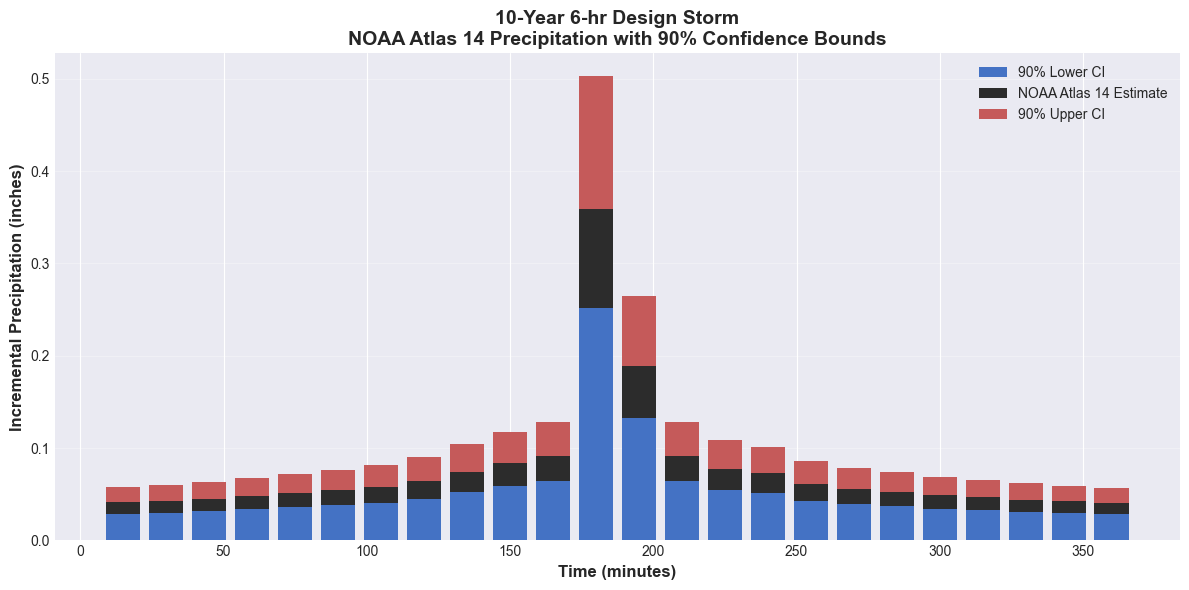

[19/42] Generating 10-yr, 12hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[20/42] Generating 10-yr, 1day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[21/42] Generating 10-yr, 2day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[22/42] Generating 25-yr, 1hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[23/42] Generating 25-yr, 2hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[24/42] Generating 25-yr, 3hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[25/42] Generating 25-yr, 6hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[26/42] Generating 25-yr, 12hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[27/42] Generating 25-yr, 1day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[28/42] Generating 25-yr, 2day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[29/42] Generating 50-yr, 1hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[30/42] Generating 50-yr, 2hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[31/42] Generating 50-yr, 3hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[32/42] Generating 50-yr, 6hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[33/42] Generating 50-yr, 12hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[34/42] Generating 50-yr, 1day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[35/42] Generating 50-yr, 2day storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[36/42] Generating 100-yr, 1hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[37/42] Generating 100-yr, 2hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[38/42] Generating 100-yr, 3hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[39/42] Generating 100-yr, 6hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.
[40/42] Generating 100-yr, 12hr storm...

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 saved.

[41/42] Displaying 100-yr, 1day storm...


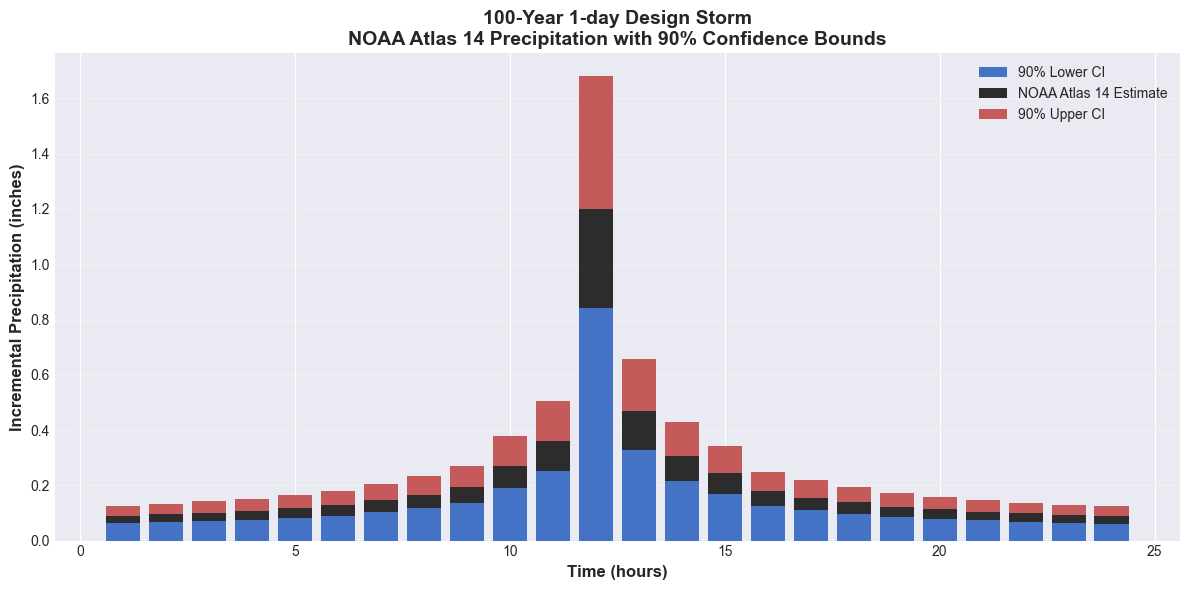

[42/42] Generating 100-yr, 2day storm... saved.

COMPLETE
✓ Generated and saved 42 hyetograph plots to: Atlas 14 Storm Hyetographs
✓ Displayed 2 key scenarios (10-Year 6-Hour and 100-Year 24-Hour)


C:\Users\billk_clb\AppData\Local\Temp\ipykernel_206348\774717399.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [12]:
# =============================================================================
# HYETOGRAPH VISUALIZATION WITH CONFIDENCE INTERVALS
# =============================================================================

print("=" * 70)
print("HYETOGRAPH VISUALIZATION WITH CONFIDENCE INTERVALS")
print("=" * 70)

# Generate ALL hyetographs and save to folder (without displaying)
print("\nGenerating and saving all hyetograph plots...")
print("(Only displaying 10-Year 6-Hour and 100-Year 24-Hour storms)\n")

# Define all scenarios
ari_values = [2, 5, 10, 25, 50, 100]
duration_values = [1, 2, 3, 6, 12, 24, 48]  # 48 = 2 days
save_dir = "Atlas 14 Storm Hyetographs"

# Create save directory
os.makedirs(save_dir, exist_ok=True)

total_plots = len(ari_values) * len(duration_values)
current = 0
generated_count = 0

for ari in ari_values:
    for duration in duration_values:
        current += 1

        # Format duration string
        if duration >= 24:
            dur_str = f"{int(duration/24)}day"
        else:
            dur_str = f"{int(duration)}hr"

        # Check if files exist
        filename = f'hyetograph_ARI_{ari}_DUR_{dur_str}_CI_point.csv'
        filepath = os.path.join(output_dir, filename)

        if not os.path.exists(filepath):
            print(f"[{current}/{total_plots}] Skipping {ari}-yr, {dur_str} - files not found")
            continue

        try:
            # Only DISPLAY these two specific plots
            if (ari == 10 and duration == 6) or (ari == 100 and duration == 24):
                print(f"\n[{current}/{total_plots}] Displaying {ari}-yr, {dur_str} storm...")
                plot_hyetograph_with_ci(ari, duration, output_dir, save_dir)
            else:
                # Generate and save without displaying
                print(f"[{current}/{total_plots}] Generating {ari}-yr, {dur_str} storm...", end='')

                # Call the function but close the plot immediately to avoid display
                import matplotlib
                matplotlib.use('Agg')  # Use non-interactive backend
                plot_hyetograph_with_ci(ari, duration, output_dir, save_dir)
                plt.close('all')  # Close all figures
                matplotlib.use('module://matplotlib_inline.backend_inline')  # Restore interactive backend

                print(" saved.")

            generated_count += 1

        except Exception as e:
            print(f"  Error: {e}")

print(f"\n{'=' * 70}")
print(f"COMPLETE")
print(f"{'=' * 70}")
print(f"✓ Generated and saved {generated_count} hyetograph plots to: {save_dir}")
print(f"✓ Displayed 2 key scenarios (10-Year 6-Hour and 100-Year 24-Hour)")

## Comparison of Total Depths Across Scenarios

In [13]:
# Hyetograph visualization completed in cell above
# All hyetograph plots have been generated and saved to "Atlas 14 Storm Hyetographs" directory

## Initialize HEC-RAS Project and Create Plans

Now we'll create a plan for each scenario in our matrix

## Plan Creation Functions

In [14]:
def get_simulation_duration_from_plan(plan_number, project):
    """
    Get the simulation duration in hours from a plan file.

    Parameters:
    - plan_number: Plan number
    - project: RAS project object

    Returns:
    - tuple: (start_datetime, end_datetime, duration_hours)
    """
    from datetime import datetime, timedelta

    plan_path = RasPlan.get_plan_path(plan_number, ras_object=project)

    with open(plan_path, 'r') as f:
        lines = f.readlines()

    # Find Simulation Date line
    for line in lines:
        if line.startswith('Simulation Date='):
            # Format: Simulation Date=10JAN2000,1200,11JAN2000,2400
            parts = line.strip().split('=')[1].split(',')

            start_date = parts[0]
            start_time = parts[1]
            end_date = parts[2]
            end_time = parts[3]

            # Parse dates (format: DDMMMYYYY, time: HHMM)
            start_dt = datetime.strptime(f"{start_date}{start_time}", "%d%b%Y%H%M")
            
            # Handle special case: HEC-RAS uses "2400" to mean midnight (end of day)
            if end_time == "2400":
                end_dt = datetime.strptime(f"{end_date}0000", "%d%b%Y%H%M")
                end_dt = end_dt + timedelta(days=1)
            else:
                end_dt = datetime.strptime(f"{end_date}{end_time}", "%d%b%Y%H%M")

            # Calculate duration in hours
            duration_hours = (end_dt - start_dt).total_seconds() / 3600

            return start_dt, end_dt, duration_hours

    # Default fallback
    return None, None, 24.0


def format_interval_for_hecras(interval_hours):
    """
    Convert interval in hours to HEC-RAS format string.

    Parameters:
    - interval_hours: Time interval in hours (e.g., 0.0833 for 5 minutes)

    Returns:
    - str: HEC-RAS format (e.g., "5MIN", "15MIN", "1HOUR")
    """
    interval_minutes = interval_hours * 60

    if interval_minutes < 1.0:
        # Less than 1 minute - shouldn't happen but handle it
        seconds = interval_minutes * 60
        return f"{int(seconds)}SEC"
    elif interval_minutes < 60:
        # Minutes
        return f"{int(interval_minutes)}MIN"
    else:
        # Hours
        hours = interval_hours
        if hours == int(hours):
            return f"{int(hours)}HOUR"
        else:
            # Fractional hours - convert to minutes
            return f"{int(interval_minutes)}MIN"


def modify_unsteady_flow_with_hyetograph(unsteady_file_path, hyetograph_file, plan_number=None, project=None):
    """
    Modifies an unsteady flow file to incorporate hyetograph data as precipitation.
    Handles time intervals and pads the hyetograph to cover the full simulation window.

    Parameters:
    - unsteady_file_path: Path to the unsteady flow file
    - hyetograph_file: Path to the hyetograph data CSV
    - plan_number: Plan number (for getting simulation duration)
    - project: RAS project object

    Returns:
    - Boolean indicating success
    """
    try:
        # Read the hyetograph data (skip comment lines)
        hyetograph_df = pd.read_csv(hyetograph_file, comment='#')

        # Get the time interval from the hyetograph
        if 'Time_hour' in hyetograph_df.columns:
            time_values = hyetograph_df['Time_hour'].values
        elif 'Time_min' in hyetograph_df.columns:
            time_values = hyetograph_df['Time_min'].values / 60.0  # Convert to hours
        else:
            raise ValueError("Could not find time column in hyetograph file")

        # Calculate interval
        if len(time_values) > 1:
            interval_hours = time_values[1] - time_values[0]
        else:
            interval_hours = time_values[0]

        # Get storm duration in hours
        storm_duration_hours = time_values[-1]

        # Get simulation duration from plan file
        if plan_number and project:
            start_dt, end_dt, sim_duration_hours = get_simulation_duration_from_plan(plan_number, project)
        else:
            # Default: assume 36-hour simulation
            sim_duration_hours = 36.0

        print(f"  Storm duration: {storm_duration_hours:.2f} hours")
        print(f"  Time interval: {interval_hours*60:.1f} minutes")
        print(f"  Simulation duration: {sim_duration_hours:.1f} hours")

        # Calculate total number of intervals needed
        total_intervals = int(sim_duration_hours / interval_hours)

        # Get precipitation values from hyetograph
        precip_values = hyetograph_df["Precipitation_in"].values

        # Calculate where to place the storm (at the beginning of simulation)
        warmup_hours = 0.0
        warmup_intervals = int(warmup_hours / interval_hours)

        # Create full precipitation array with zeros
        full_precip = np.zeros(total_intervals)

        # Insert storm values after warmup period
        storm_intervals = len(precip_values)
        if warmup_intervals + storm_intervals <= total_intervals:
            full_precip[warmup_intervals:warmup_intervals + storm_intervals] = precip_values
        else:
            # If storm doesn't fit, place at start
            end_idx = min(storm_intervals, total_intervals)
            full_precip[0:end_idx] = precip_values[0:end_idx]

        print(f"  Total intervals in simulation: {total_intervals}")
        print(f"  Storm placed at interval {warmup_intervals} (at simulation start)")

        # Read the unsteady flow file
        with open(unsteady_file_path, 'r') as file:
            lines = file.readlines()

        # Find the Interval line and update it
        interval_line_idx = None
        for i, line in enumerate(lines):
            if line.startswith("Interval="):
                interval_line_idx = i
                break

        if interval_line_idx is not None:
            # Update the interval
            interval_str = format_interval_for_hecras(interval_hours)
            lines[interval_line_idx] = f"Interval={interval_str}\n"
            print(f"  Updated Interval to: {interval_str}")

        # Find the Precipitation Hydrograph section
        precip_hydrograph_index = None
        for i, line in enumerate(lines):
            if line.startswith("Precipitation Hydrograph="):
                precip_hydrograph_index = i
                break

        if precip_hydrograph_index is None:
            print("Cannot find Precipitation Hydrograph section in unsteady file.")
            return False

        # Create the Precipitation Hydrograph line
        precip_line = f"Precipitation Hydrograph= {len(full_precip)} \n"

        # Format the values in groups of 10 per line
        value_lines = []
        for i in range(0, len(full_precip), 10):
            row_values = full_precip[i:i+10]
            row_line = "".join([f"{value:8.2f}" for value in row_values]) + "\n"
            value_lines.append(row_line)

        # Find end of current hydrograph
        current_line = precip_hydrograph_index + 1
        end_markers = ["DSS Path=", "Use DSS=", "Use Fixed Start Time="]
        while current_line < len(lines) and not any(lines[current_line].startswith(marker) for marker in end_markers):
            current_line += 1

        # Replace the hydrograph section
        lines[precip_hydrograph_index:current_line] = [precip_line] + value_lines

        # Write the modified file back
        with open(unsteady_file_path, 'w') as file:
            file.writelines(lines)

        return True

    except Exception as e:
        print(f"Error modifying unsteady flow file: {str(e)}")
        import traceback
        traceback.print_exc()
        return False


def create_plan_for_scenario(scenario_row, base_plan, project):
    """
    Creates a new plan for a specific scenario.

    Parameters:
    - scenario_row: Row from scenario DataFrame
    - base_plan: Base plan number to clone from
    - project: RAS project object

    Returns:
    - new_plan_number
    """
    ari = scenario_row['ari']
    duration = scenario_row['duration_hrs']
    ci_level = scenario_row['ci_level']
    hyetograph_file = scenario_row['hyetograph_file']

    # Format duration string
    if duration >= 24:
        dur_str = f"{int(duration/24)}D"
    else:
        dur_str = f"{int(duration)}H"

    # Create plan name (keep it short for HEC-RAS)
    ci_abbrev = ci_level[0].upper()  # L, P, or U
    plan_name = f"{ari}YR-{dur_str}-{ci_abbrev}"

    # Clone the base plan
    new_plan_number = RasPlan.clone_plan(base_plan, new_shortid=plan_name, ras_object=project)

    # Get unsteady number from base plan
    base_unsteady = None
    for _, row in project.plan_df.iterrows():
        if row['plan_number'] == base_plan:
            base_unsteady = row.get('unsteady_number', None)
            break

    if base_unsteady is None:
        raise ValueError(f"Could not find unsteady flow file for base plan {base_plan}")

    # Clone the unsteady flow file
    new_unsteady_number = RasPlan.clone_unsteady(base_unsteady, ras_object=project)

    # Get unsteady file path
    unsteady_file_path = RasPlan.get_unsteady_path(new_unsteady_number, ras_object=project)

    # Update the flow title
    new_title = f"{ari}YR-{dur_str}-{ci_level.upper()} Storm"
    RasUnsteady.update_flow_title(unsteady_file_path, new_title, ras_object=project)

    # Modify the unsteady flow file with the hyetograph data
    # Pass plan number and project so we can get simulation duration
    hyetograph_file_abs = Path(hyetograph_file).absolute()
    success = modify_unsteady_flow_with_hyetograph(
        unsteady_file_path,
        hyetograph_file_abs,
        plan_number=new_plan_number,
        project=project
    )
    if not success:
        raise RuntimeError(f"Failed to apply hyetograph data to plan {new_plan_number}")

    # Assign the unsteady flow file to the plan
    RasPlan.set_unsteady(new_plan_number, new_unsteady_number, ras_object=project)

    return new_plan_number

print("Plan creation functions defined")

Plan creation functions defined


## Handling the 99-Plan Limit in HEC-RAS

**IMPORTANT**: HEC-RAS projects can only contain a maximum of 99 plans. Since this analysis requires 126 scenarios (6 AEPs × 7 durations × 3 confidence levels), we need to distribute scenarios across multiple project copies.

**Solution Approach:**
1. **Automatic Project Distribution**: The `distribute_scenarios_across_projects()` function automatically:
   - Checks existing plan count in the base project
   - Calculates available slots (99 - existing plans)
   - Creates multiple project copies as needed
   - Groups scenarios logically (by AEP) to keep related runs together
   
2. **Project Naming**: New projects are created with meaningful names:
   - Format: `{project_name}{suffix}_{number}`
   - Example: `Davis_atlas14_01`, `Davis_atlas14_02`, etc.
   - The suffix is user-configurable (default: `_atlas14`)

3. **Plan Descriptions**: Each plan's description includes:
   - AEP (return period)
   - Storm duration
   - Confidence level
   - Analysis set identifier (the folder suffix)
   
4. **Original Project Preservation**: The base project is never modified - all new plans are created in project copies

**Configuration Options:**
- `folder_suffix`: Change the suffix added to project folders (default: `"_atlas14"`)
- Modify the grouping strategy in `distribute_scenarios_across_projects()` if needed
  (currently groups by AEP to keep related scenarios together)

In [15]:
## Multi-Project Management Functions for 99-Plan Limit

import shutil

def copy_ras_project(source_folder, dest_folder, suffix=""):
    """
    Copy a HEC-RAS project to a new folder.

    Parameters:
    -----------
    source_folder : Path or str
        Source project folder
    dest_folder : Path or str
        Destination folder
    suffix : str, optional
        Suffix to add to project name

    Returns:
    --------
    Path : Path to destination folder
    """
    source_folder = Path(source_folder)
    dest_folder = Path(dest_folder)

    # Create destination
    dest_folder.mkdir(parents=True, exist_ok=True)

    # Copy all files
    for item in source_folder.iterdir():
        if item.is_file():
            shutil.copy2(item, dest_folder / item.name)
        elif item.is_dir() and item.name not in ['compute_uncertainty', '.ipynb_checkpoints']:
            shutil.copytree(item, dest_folder / item.name, dirs_exist_ok=True)

    print(f"Copied project to: {dest_folder}")
    return dest_folder


def distribute_scenarios_across_projects(scenario_df, base_project_path, base_plan="02",
                                         folder_suffix="_atlas14", ras_version="6.6"):
    """
    Distribute scenarios across multiple HEC-RAS project copies to handle 99-plan limit.

    Parameters:
    -----------
    scenario_df : DataFrame
        Scenarios to process
    base_project_path : Path or str
        Original project path
    base_plan : str
        Base plan number to clone from
    folder_suffix : str
        Suffix for project folders (default: "_atlas14")
    ras_version : str
        HEC-RAS version

    Returns:
    --------
    DataFrame : scenario_df with added columns: project_folder, project_object, plan_number
    """
    base_project_path = Path(base_project_path)

    # Check base project existing plans
    temp_proj = RasPrj()
    init_ras_project(base_project_path, ras_version, ras_object=temp_proj)
    existing_plans_in_base = len(temp_proj.plan_df)

    print("="*70)
    print("DISTRIBUTING SCENARIOS ACROSS PROJECTS (99-PLAN LIMIT)")
    print("="*70)
    print(f"\nBase project has {existing_plans_in_base} existing plans")
    print(f"Maximum plans per project: 99")
    print(f"Total scenarios to distribute: {len(scenario_df)}\n")

    # Calculate how many scenarios we can fit per project
    max_scenarios_per_project = 99 - existing_plans_in_base

    # Group scenarios by ARI to keep related scenarios together
    ari_groups = scenario_df.groupby('ari')

    results_list = []
    current_project_num = 1
    current_project_path = None
    current_project_obj = None
    current_project_plan_count = 0

    for ari, ari_df in ari_groups:
        num_scenarios_in_group = len(ari_df)

        print(f"Processing {ari}-year AEP ({num_scenarios_in_group} scenarios)...")

        # Check if we need to create a new project
        if current_project_obj is None or (current_project_plan_count + num_scenarios_in_group) > max_scenarios_per_project:
            # Create a new project
            print(f"\n{'='*70}")
            print(f"Creating Project #{current_project_num}")
            print(f"{'='*70}")

            # Create project folder with meaningful name
            project_folder_name = f"{base_project_path.name}{folder_suffix}_{current_project_num:02d}"
            current_project_path = base_project_path.parent / project_folder_name

            # Copy the project
            copy_ras_project(base_project_path, current_project_path)

            # Initialize the project
            current_project_obj = RasPrj()
            init_ras_project(current_project_path, ras_version, ras_object=current_project_obj)

            # Reset counter to existing plans in the new copy
            current_project_plan_count = len(current_project_obj.plan_df)
            print(f"Project initialized with {current_project_plan_count} existing plans")
            print(f"Available slots: {99 - current_project_plan_count}")

            current_project_num += 1

        # Add all scenarios from this ARI group to the current project
        for idx, scenario in ari_df.iterrows():
            scenario['project_folder'] = str(current_project_path)
            scenario['project_object'] = current_project_obj
            scenario['project_suffix'] = folder_suffix
            results_list.append(scenario)
            current_project_plan_count += 1

        print(f"  Added {num_scenarios_in_group} scenarios to project {current_project_path.name}")
        print(f"  Current plan count: {current_project_plan_count}/{99}")

    # Create results DataFrame
    results_df = pd.DataFrame(results_list)

    # Summary
    print(f"\n{'='*70}")
    print(f"DISTRIBUTION SUMMARY")
    print(f"{'='*70}")
    print(f"Total scenarios: {len(results_df)}")
    print(f"Projects created: {current_project_num - 1}")
    print(f"\nScenarios per project:")
    for proj_folder in results_df['project_folder'].unique():
        count = len(results_df[results_df['project_folder'] == proj_folder])
        print(f"  {Path(proj_folder).name}: {count} scenarios")

    return results_df


def create_plan_with_description(scenario_row, base_plan, project, folder_suffix):
    """
    Creates a new plan for a scenario with description including folder suffix.

    Parameters:
    - scenario_row: Row from scenario DataFrame
    - base_plan: Base plan number to clone from
    - project: RAS project object
    - folder_suffix: Folder suffix to add to description

    Returns:
    - new_plan_number
    """
    ari = scenario_row['ari']
    duration = scenario_row['duration_hrs']
    ci_level = scenario_row['ci_level']
    hyetograph_file = scenario_row['hyetograph_file']

    # Format duration string
    if duration >= 24:
        dur_str = f"{int(duration/24)}D"
    else:
        dur_str = f"{int(duration)}H"

    # Create plan name (keep it short for HEC-RAS)
    ci_abbrev = ci_level[0].upper()  # L, P, or U
    plan_name = f"{ari}YR-{dur_str}-{ci_abbrev}"

    # Clone the base plan
    new_plan_number = RasPlan.clone_plan(base_plan, new_shortid=plan_name, ras_object=project)

    # Update description with folder suffix
    description_text = f"Atlas 14 Uncertainty Analysis\n"
    description_text += f"AEP: {ari} years\n"
    description_text += f"Duration: {duration} hours\n"
    description_text += f"Confidence Level: {ci_level}\n"
    description_text += f"Analysis Set: {folder_suffix}"

    #RasPlan.update_plan_description(new_plan_number, description_text, ras_object=project)

    # Get unsteady number from base plan
    base_unsteady = None
    for _, row in project.plan_df.iterrows():
        if row['plan_number'] == base_plan:
            base_unsteady = row.get('unsteady_number', None)
            break

    if base_unsteady is None:
        raise ValueError(f"Could not find unsteady flow file for base plan {base_plan}")

    # Clone the unsteady flow file
    new_unsteady_number = RasPlan.clone_unsteady(base_unsteady, ras_object=project)

    # Get unsteady file path
    unsteady_file_path = RasPlan.get_unsteady_path(new_unsteady_number, ras_object=project)

    # Update the flow title
    new_title = f"{ari}YR-{dur_str}-{ci_level.upper()} Storm"
    RasUnsteady.update_flow_title(unsteady_file_path, new_title, ras_object=project)

    # Modify the unsteady flow file with the hyetograph data
    # Need to ensure hyetograph path is accessible from new project location
    hyetograph_file_abs = Path(hyetograph_file).absolute()
    success = modify_unsteady_flow_with_hyetograph(
        unsteady_file_path,
        hyetograph_file_abs,
        plan_number=new_plan_number,
        project=project
    )
    if not success:
        raise RuntimeError(f"Failed to apply hyetograph data to plan {new_plan_number}")

    # Assign the unsteady flow file to the plan
    RasPlan.set_unsteady(new_plan_number, new_unsteady_number, ras_object=project)

    return new_plan_number


print("Multi-project management functions defined")

Multi-project management functions defined


In [16]:
# Distribute scenarios across projects and create plans
print("="*70)
print("CREATING PLANS WITH 99-PLAN LIMIT HANDLING")
print("="*70)
print(f"\nTotal scenarios to process: {len(scenario_df)}")
print(f"Base project: {pipes_ex_path}\n")

# Distribute scenarios across multiple projects as needed
scenario_df_distributed = distribute_scenarios_across_projects(
    scenario_df, 
    base_project_path=pipes_ex_path,
    base_plan=base_plan,
    folder_suffix="_atlas14",
    ras_version="6.6"
)

# Now create plans in each project
print(f"\n{'='*70}")
print("CREATING PLANS IN DISTRIBUTED PROJECTS")
print(f"{'='*70}\n")

plan_numbers = []
failed_scenarios = []

# Group by project
project_groups = scenario_df_distributed.groupby('project_folder')

for proj_folder, proj_scenarios in project_groups:
    print(f"\n{'='*70}")
    print(f"Processing Project: {Path(proj_folder).name}")
    print(f"Scenarios: {len(proj_scenarios)}")
    print(f"{'='*70}")
    
    # Get the project object (they should all be the same within a group)
    proj_obj = proj_scenarios.iloc[0]['project_object']
    folder_suffix = proj_scenarios.iloc[0]['project_suffix']
    
    for idx, row in proj_scenarios.iterrows():
        try:
            new_plan = create_plan_with_description(row, base_plan, proj_obj, folder_suffix)
            plan_numbers.append(new_plan)
            
            # Update the row with the plan number
            scenario_df_distributed.at[idx, 'plan_number'] = new_plan
            
        except Exception as e:
            print(f"  Error creating plan for scenario {idx}: {e}")
            failed_scenarios.append(idx)
            plan_numbers.append(None)
            scenario_df_distributed.at[idx, 'plan_number'] = None
    
    # Show progress
    successful = len([p for p in plan_numbers if p is not None])
    print(f"\nProject {Path(proj_folder).name}: Created {len(proj_scenarios)} plans")

# Remove failed scenarios
scenario_df = scenario_df_distributed[scenario_df_distributed['plan_number'].notna()].copy()

print(f"\n{'='*70}")
print("PLAN CREATION SUMMARY")
print(f"{'='*70}")
print(f"✓ Successfully created {len(plan_numbers) - len(failed_scenarios)} plans")
if failed_scenarios:
    print(f"✗ Failed to create {len(failed_scenarios)} plans")

print(f"\nPlan Summary (first 15 rows):")
display.display(scenario_df[['ari', 'duration_hrs', 'ci_level', 'plan_number', 'project_folder']].head(15))

# Save updated scenario list
scenario_df.to_csv('scenarios_with_plans.csv', index=False)
print(f"\nScenario list with plan numbers saved to: scenarios_with_plans.csv")

2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap


CREATING PLANS WITH 99-PLAN LIMIT HANDLING

Total scenarios to process: 126
Base project: c:\GH\ras-commander\examples\A14_Examples\Davis

DISTRIBUTING SCENARIOS ACROSS PROJECTS (99-PLAN LIMIT)

Base project has 1 existing plans
Maximum plans per project: 99
Total scenarios to distribute: 126

Processing 2-year AEP (21 scenarios)...

Creating Project #1
Copied project to: c:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01
Project initialized with 1 existing plans
Available slots: 98
  Added 21 scenarios to project Davis_atlas14_01
  Current plan count: 22/99
Processing 5-year AEP (21 scenarios)...
  Added 21 scenarios to project Davis_atlas14_01
  Current plan count: 43/99
Processing 10-year AEP (21 scenarios)...
  Added 21 scenarios to project Davis_atlas14_01
  Current plan count: 64/99
Processing 25-year AEP (21 scenarios)...
  Added 21 scenarios to project Davis_atlas14_01
  Current plan count: 85/99
Processing 50-year AEP (21 scenarios)...

Creating Project #2
Copied proje

2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p01
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p01
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 01
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.

Project initialized with 1 existing plans
Available slots: 98
  Added 21 scenarios to project Davis_atlas14_02
  Current plan count: 22/99
Processing 100-year AEP (21 scenarios)...
  Added 21 scenarios to project Davis_atlas14_02
  Current plan count: 43/99

DISTRIBUTION SUMMARY
Total scenarios: 126
Projects created: 2

Scenarios per project:
  Davis_atlas14_01: 84 scenarios
  Davis_atlas14_02: 42 scenarios

CREATING PLANS IN DISTRIBUTED PROJECTS


Processing Project: Davis_atlas14_01
Scenarios: 84
  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p03
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p03
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 03
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u03
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)


2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p04
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p04
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 04
2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u04
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Updated Interval to: 5MIN
  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:42 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '2YR-2H-LOWER Storm'
2025-11-18 06:21:42 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u05
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p06
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p06
2025-11-18 06:21:42 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 06
2025-11-18 06:21:43 - ras_comma

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u07
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 07
2025-11-18 06:21:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:43 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '2YR-2H-UPPER Storm'
2025-11-18 06:21:43 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u07
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p08
2025-11-18 06:21:43 - ras_c

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u09
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u09
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 09
2025-11-18 06:21:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:43 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '2YR-3H-POINT Storm'
2025-11-18 06:21:43 - ras_co

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u11
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u11
2025-11-18 06:21:43 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 11
2025-11-18 06:21:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:43 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '2YR-6H-LOWER Storm'
2025-11-18 06:21:43 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u11
2025-11-18 06:21:43 - ras_c

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN
  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u13
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u13
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 13
2025-11-18 06:21:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:44 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '2YR-6H-UPPER Storm'
2025-11-18 06:21:44 - ras_co

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN
  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 15
2025-11-18 06:21:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u15
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u15
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 15
2025-11-18 06:21:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:44 - ras_commander.RasUnsteady - INFO - Upda

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN
  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p17
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p17
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 17
2025-11-18 06:21:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u17
2025-11-18 06:21:44 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR
  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p19
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 19
2025-11-18 06:21:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u19
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u19
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 19
2025-11-18 06:21:45 - ras_commander.RasMap - INFO - Successfully parsed

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR
  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p21
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p21
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 21
2025-11-18 06:21:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u21
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR
  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p23
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p23
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 23
2025-11-18 06:21:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u23
2025-11-18 06:21:45 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:46 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u24
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p25
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p25
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 25
2025-11-18 06:21:46 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p26
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p26
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 26
2025-11-18 06:21:46 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u26
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p28
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p28
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 28
2025-11-18 06:21:46 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u28
2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:46 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p29
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p29
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 29
2025-11-18 06:21:47 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u29
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p31
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p31
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 31
2025-11-18 06:21:47 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u31
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:47 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:47 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-3H-UPPER Storm'
2025-11-18 06:21:47 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u31
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p32
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p32
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 32
2025-11-18 06:21:47 - ras_comma

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:47 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-6H-LOWER Storm'
2025-11-18 06:21:47 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u32
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p33
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p33
2025-11-18 06:21:47 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 33
2025-11-18 06:21:47 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:47 - ras_comma

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-6H-POINT Storm'
2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u33
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p34
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p34
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 34
2025-11-18 06:21:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:48 - ras_comma

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-6H-UPPER Storm'
2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u34
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p35
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p35
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 35
2025-11-18 06:21:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:48 - ras_comma

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-12H-LOWER Storm'
2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u35
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p36
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p36
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 36
2025-11-18 06:21:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:48 - ras_comm

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-12H-POINT Storm'
2025-11-18 06:21:48 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u36
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p37
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p37
2025-11-18 06:21:48 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 37
2025-11-18 06:21:48 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:48 - ras_comm

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-12H-UPPER Storm'
2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u37
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p38
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p38
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 38
2025-11-18 06:21:49 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:49 - ras_comm

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:49 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-1D-LOWER Storm'
2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u38
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p39
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p39
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 39
2025-11-18 06:21:49 - ras_comma

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-1D-POINT Storm'
2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u39
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p40
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p40
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 40
2025-11-18 06:21:49 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:49 - ras_comma

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-1D-UPPER Storm'
2025-11-18 06:21:49 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u40
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p41
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p41
2025-11-18 06:21:49 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 41
2025-11-18 06:21:49 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:50 - ras_comma

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:50 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-2D-LOWER Storm'
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u41
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p42
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p42
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 42
2025-11-18 06:21:50 - ras_comma

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:50 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-2D-POINT Storm'
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u42
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p43
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p43
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 43
2025-11-18 06:21:50 - ras_comma

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-2D-UPPER Storm'
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u43
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p44
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p44
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 44
2025-11-18 06:21:50 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:50 - ras_comma

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:50 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-1H-LOWER Storm'
2025-11-18 06:21:50 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u44
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p45
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p45
2025-11-18 06:21:50 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 45
2025-11-18 06:21:51 - ras_comm

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:51 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:51 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-1H-POINT Storm'
2025-11-18 06:21:51 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u45
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p46
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p46
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 46
2025-11-18 06:21:51 - ras_comm

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:51 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:51 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-1H-UPPER Storm'
2025-11-18 06:21:51 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u46
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p47
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p47
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 47
2025-11-18 06:21:51 - ras_comm

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:51 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:51 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-2H-LOWER Storm'
2025-11-18 06:21:51 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u47
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p48
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p48
2025-11-18 06:21:51 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 48
2025-11-18 06:21:51 - ras_comm

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:52 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-2H-POINT Storm'
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u48
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p49
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p49
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 49
2025-11-18 06:21:52 - ras_comm

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:52 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-2H-UPPER Storm'
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u49
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p50
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p50
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 50
2025-11-18 06:21:52 - ras_comm

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:52 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-3H-LOWER Storm'
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u50
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p51
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p51
2025-11-18 06:21:52 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 51
2025-11-18 06:21:52 - ras_comm

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:52 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-3H-POINT Storm'
2025-11-18 06:21:52 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u51
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p52
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p52
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 52
2025-11-18 06:21:53 - ras_comm

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u52
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 52
2025-11-18 06:21:53 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:53 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-3H-UPPER Storm'
2025-11-18 06:21:53 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u52
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p53
2025-11-18 06:21:53 - ras_

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:53 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:53 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-6H-LOWER Storm'
2025-11-18 06:21:53 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u53
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p54
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p54
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 54
2025-11-18 06:21:53 - ras_comm

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:53 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:53 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-6H-POINT Storm'
2025-11-18 06:21:53 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u54
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p55
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p55
2025-11-18 06:21:53 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 55
2025-11-18 06:21:54 - ras_comm

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:54 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:54 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-6H-UPPER Storm'
2025-11-18 06:21:54 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u55
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p56
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p56
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 56
2025-11-18 06:21:54 - ras_comm

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:21:54 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:54 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-12H-LOWER Storm'
2025-11-18 06:21:54 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u56
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p57
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p57
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 57
2025-11-18 06:21:54 - ras_com

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:54 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:54 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-12H-POINT Storm'
2025-11-18 06:21:54 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u57
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p58
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p58
2025-11-18 06:21:54 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 58
2025-11-18 06:21:55 - ras_com

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u58
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u58
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 58
2025-11-18 06:21:55 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:55 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-12H-UPPER Storm'
2025-11-18 06:21:55 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u58
2025-11-18 06:21:55 - ras

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:21:55 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:55 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-1D-LOWER Storm'
2025-11-18 06:21:55 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u59
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p60
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p60
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 60
2025-11-18 06:21:55 - ras_comm

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:55 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:55 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-1D-POINT Storm'
2025-11-18 06:21:55 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u60
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p61
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p61
2025-11-18 06:21:55 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 61
2025-11-18 06:21:56 - ras_comm

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:56 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-1D-UPPER Storm'
2025-11-18 06:21:56 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u61
2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p62
2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p62
2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 62
2025-11-18 06:21:56 - ras_comm

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:56 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-2D-LOWER Storm'
2025-11-18 06:21:56 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u62
2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p63
2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p63
2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 63
2025-11-18 06:21:56 - ras_comm

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:56 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 63
2025-11-18 06:21:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:56 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-2D-POINT Storm'
2025-11-18 06:21:56 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u63
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p64
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p64
2025-11-18 06:21:57 - ras_

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u64
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u64
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 64
2025-11-18 06:21:57 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:57 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-2D-UPPER Storm'
2025-11-18 06:21:57 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u64
2025-11-18 06:21:57 - ras_

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u65
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u65
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 65
2025-11-18 06:21:57 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:57 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-1H-LOWER Storm'
2025-11-18 06:21:57 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u65
2025-11-18 06:21:57 - ras_

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u66
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u66
2025-11-18 06:21:57 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 66
2025-11-18 06:21:58 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:58 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-1H-POINT Storm'
2025-11-18 06:21:58 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u66
2025-11-18 06:21:58 - ras_

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:58 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u67
2025-11-18 06:21:58 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u67
2025-11-18 06:21:58 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 67
2025-11-18 06:21:58 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:58 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-1H-UPPER Storm'
2025-11-18 06:21:58 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u67
2025-11-18 06:21:58 - ras_

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:58 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u68
2025-11-18 06:21:58 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u68
2025-11-18 06:21:58 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 68
2025-11-18 06:21:58 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:58 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-2H-LOWER Storm'
2025-11-18 06:21:58 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u68
2025-11-18 06:21:58 - ras_

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u69
2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u69
2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 69
2025-11-18 06:21:59 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:59 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-2H-POINT Storm'
2025-11-18 06:21:59 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u69
2025-11-18 06:21:59 - ras_

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u70
2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u70
2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 70
2025-11-18 06:21:59 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:21:59 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-2H-UPPER Storm'
2025-11-18 06:21:59 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u70
2025-11-18 06:21:59 - ras_

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u71
2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u71
2025-11-18 06:21:59 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 71
2025-11-18 06:22:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:00 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-3H-LOWER Storm'
2025-11-18 06:22:00 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u71
2025-11-18 06:22:00 - ras_

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:00 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u72
2025-11-18 06:22:00 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u72
2025-11-18 06:22:00 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 72
2025-11-18 06:22:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:00 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-3H-POINT Storm'
2025-11-18 06:22:00 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u72
2025-11-18 06:22:00 - ras_

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:00 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u73
2025-11-18 06:22:00 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u73
2025-11-18 06:22:00 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 73
2025-11-18 06:22:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:00 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-3H-UPPER Storm'
2025-11-18 06:22:00 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u73
2025-11-18 06:22:00 - ras_

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u74
2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u74
2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 74
2025-11-18 06:22:01 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:01 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-6H-LOWER Storm'
2025-11-18 06:22:01 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u74
2025-11-18 06:22:01 - ras_

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u75
2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u75
2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 75
2025-11-18 06:22:01 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:01 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-6H-POINT Storm'
2025-11-18 06:22:01 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u75
2025-11-18 06:22:01 - ras_

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u76
2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u76
2025-11-18 06:22:01 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 76
2025-11-18 06:22:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:02 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-6H-UPPER Storm'
2025-11-18 06:22:02 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u76
2025-11-18 06:22:02 - ras_

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u77
2025-11-18 06:22:02 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u77
2025-11-18 06:22:02 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 77
2025-11-18 06:22:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:02 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-12H-LOWER Storm'
2025-11-18 06:22:02 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u77
2025-11-18 06:22:02 - ras

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u78
2025-11-18 06:22:02 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u78
2025-11-18 06:22:02 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 78
2025-11-18 06:22:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:03 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-12H-POINT Storm'
2025-11-18 06:22:03 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u78
2025-11-18 06:22:03 - ras

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u79
2025-11-18 06:22:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u79
2025-11-18 06:22:03 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 79
2025-11-18 06:22:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:03 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-12H-UPPER Storm'
2025-11-18 06:22:03 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u79
2025-11-18 06:22:03 - ras

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u80
2025-11-18 06:22:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u80
2025-11-18 06:22:03 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 80
2025-11-18 06:22:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:03 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-1D-LOWER Storm'
2025-11-18 06:22:03 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u80
2025-11-18 06:22:03 - ras_

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u81
2025-11-18 06:22:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u81
2025-11-18 06:22:04 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 81
2025-11-18 06:22:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:04 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-1D-POINT Storm'
2025-11-18 06:22:04 - ras_c

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u82
2025-11-18 06:22:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u82
2025-11-18 06:22:04 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 82
2025-11-18 06:22:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:04 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-1D-UPPER Storm'
2025-11-18 06:22:04 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u82
2025-11-18 06:22:04 - ras_

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u83
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u83
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 83
2025-11-18 06:22:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:05 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-2D-LOWER Storm'
2025-11-18 06:22:05 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u83
2025-11-18 06:22:05 - ras_

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u84
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u84
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 84
2025-11-18 06:22:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:05 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-2D-POINT Storm'
2025-11-18 06:22:05 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u84
2025-11-18 06:22:05 - ras_

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u85
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.u85
2025-11-18 06:22:05 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 85
2025-11-18 06:22:05 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-2D-UPPER Storm'
2025-11-18 06:22:06 - ras_c

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR

Project Davis_atlas14_01: Created 84 plans

Processing Project: Davis_atlas14_02
Scenarios: 42
  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 03
2025-11-18 06:22:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u03
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u03
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 03
2025-11-18 06:22:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUnsteady - INFO - Upda

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u05
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u05
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 05
2025-11-18 06:22:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '50YR-2H-LOWER Storm'
2025-11-18 06:22:06 - ras_c

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u07
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u07
2025-11-18 06:22:06 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 07
2025-11-18 06:22:06 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:06 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '50YR-2H-UPPER Storm'
2025-11-18 06:22:06 - ras_c

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u09
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u09
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 09
2025-11-18 06:22:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:07 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '50YR-3H-POINT Storm'
2025-11-18 06:22:07 - ras_c

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u11
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u11
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 11
2025-11-18 06:22:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:07 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '50YR-6H-LOWER Storm'
2025-11-18 06:22:07 - ras_c

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN
  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 13
2025-11-18 06:22:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u13
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u13
2025-11-18 06:22:07 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 13
2025-11-18 06:22:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:07 - ras_commander.RasUnsteady - INFO - Upda

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN
  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p15
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p15
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 15
2025-11-18 06:22:08 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u15
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN
  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p17
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p17
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 17
2025-11-18 06:22:08 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u17
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR
  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p19
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p19
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 19
2025-11-18 06:22:08 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u19
2025-11-18 06:22:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR
  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p21
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p21
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 21
2025-11-18 06:22:09 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u21
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR
  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p23
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p23
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 23
2025-11-18 06:22:09 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u23
2025-11-18 06:22:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN
  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p25
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p25
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 25
2025-11-18 06:22:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u25
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 1.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p27
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p27
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 27
2025-11-18 06:22:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u27
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:10 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-2H-POINT Storm'
2025-11-18 06:22:10 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u27
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p28
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p28
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 28
2025-11-18 06:22:10 - ras_com

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p29
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p29
2025-11-18 06:22:10 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 29
2025-11-18 06:22:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u29
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\

  Storm duration: 2.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-3H-LOWER Storm'
2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u29
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p30
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p30
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 30
2025-11-18 06:22:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:11 - ras_com

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u30
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p31
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p31
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 31
2025-11-18 06:22:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u01 to C:\GH\ras

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-3H-UPPER Storm'
2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u31
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p32
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p32
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 32
2025-11-18 06:22:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:11 - ras_com

  Storm duration: 3.00 hours
  Time interval: 5.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 432
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 5MIN


2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-6H-LOWER Storm'
2025-11-18 06:22:11 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u32
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p33
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p33
2025-11-18 06:22:11 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 33
2025-11-18 06:22:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:11 - ras_com

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-6H-POINT Storm'
2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u33
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p34
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p34
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 34
2025-11-18 06:22:12 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:12 - ras_com

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:12 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-6H-UPPER Storm'
2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u34
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p35
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p35
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 35
2025-11-18 06:22:12 - ras_com

  Storm duration: 6.00 hours
  Time interval: 15.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 144
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 15MIN


2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-12H-LOWER Storm'
2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u35
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p36
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p36
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 36
2025-11-18 06:22:12 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:12 - ras_co

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-12H-POINT Storm'
2025-11-18 06:22:12 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u36
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p37
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p37
2025-11-18 06:22:12 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 37
2025-11-18 06:22:13 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:13 - ras_co

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:13 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-12H-UPPER Storm'
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u37
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p38
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p38
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 38
2025-11-18 06:22:13 - ras_co

  Storm duration: 12.00 hours
  Time interval: 30.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 72
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 30MIN


2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-1D-LOWER Storm'
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u38
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p39
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p39
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 39
2025-11-18 06:22:13 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:13 - ras_com

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:13 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-1D-POINT Storm'
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u39
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p40
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p40
2025-11-18 06:22:13 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 40
2025-11-18 06:22:13 - ras_com

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:13 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-1D-UPPER Storm'
2025-11-18 06:22:13 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u40
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p41
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p41
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 41
2025-11-18 06:22:14 - ras_com

  Storm duration: 24.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:14 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-2D-LOWER Storm'
2025-11-18 06:22:14 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u41
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p42
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p42
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 42
2025-11-18 06:22:14 - ras_com

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:14 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-2D-POINT Storm'
2025-11-18 06:22:14 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u42
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p02 to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p43
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p43
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 43
2025-11-18 06:22:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:14 - ras_com

  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR


2025-11-18 06:22:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.rasmap
2025-11-18 06:22:14 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-2D-UPPER Storm'
2025-11-18 06:22:14 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.u43


  Storm duration: 48.00 hours
  Time interval: 60.0 minutes
  Simulation duration: 36.0 hours
  Total intervals in simulation: 36
  Storm placed at interval 0 (at simulation start)
  Updated Interval to: 1HOUR

Project Davis_atlas14_02: Created 42 plans

PLAN CREATION SUMMARY
✓ Successfully created 126 plans

Plan Summary (first 15 rows):


,ari,duration_hrs,ci_level,plan_number,project_folder
0,2,1,lower,01,c:\GH\ras-commander\examples\A14_Examples\Davi...
1,2,1,point,03,c:\GH\ras-commander\examples\A14_Examples\Davi...
2,2,1,upper,04,c:\GH\ras-commander\examples\A14_Examples\Davi...
3,2,2,lower,05,c:\GH\ras-commander\examples\A14_Examples\Davi...
4,2,2,point,06,c:\GH\ras-commander\examples\A14_Examples\Davi...
5,2,2,upper,07,c:\GH\ras-commander\examples\A14_Examples\Davi...
6,2,3,lower,08,c:\GH\ras-commander\examples\A14_Examples\Davi...
7,2,3,point,09,c:\GH\ras-commander\examples\A14_Examples\Davi...
8,2,3,upper,10,c:\GH\ras-commander\examples\A14_Examples\Davi...
9,2,6,lower,11,c:\GH\ras-commander\examples\A14_Examples\Davi...



Scenario list with plan numbers saved to: scenarios_with_plans.csv


In [17]:
# Set computation parameters for all new plans across all projects
print("="*70)
print("CONFIGURING COMPUTATION PARAMETERS ACROSS ALL PROJECTS")
print("="*70)

# Group by project
project_groups = scenario_df.groupby('project_folder')

total_configured = 0

for proj_folder, proj_scenarios in project_groups:
    print(f"\nConfiguring {len(proj_scenarios)} plans in: {Path(proj_folder).name}")
    
    # Get the project object
    proj_obj = proj_scenarios.iloc[0]['project_object']
    
    for idx, row in proj_scenarios.iterrows():
        plan_number = row['plan_number']
        
        try:
            RasPlan.set_num_cores(plan_number, 2, ras_object=proj_obj)
#            RasPlan.update_plan_intervals(
#                plan_number,
#                computation_interval="15MIN",
#                output_interval="30MIN",
#                mapping_interval="1HOUR",
#                ras_object=proj_obj
#            )
            total_configured += 1
            
        except Exception as e:
            print(f"  Error configuring plan {plan_number}: {e}")

print(f"\n{'='*70}")
print(f"CONFIGURATION SUMMARY")
print(f"{'='*70}")
print(f"✓ Configured {total_configured} plans across {len(project_groups)} projects")
print("  - Cores per plan: 2")
#print("  - Computation interval: 15 MIN")
#print("  - Output interval: 30 MIN")
#print("  - Mapping interval: 1 HOUR")

2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p01
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p01
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p03
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p03
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p04
2025-11-18 06:22:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p04
2025-11-18 06:22:15 - ras_comma

CONFIGURING COMPUTATION PARAMETERS ACROSS ALL PROJECTS

Configuring 84 plans in: Davis_atlas14_01


2025-11-18 06:22:15 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p06
2025-11-18 06:22:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p06
2025-11-18 06:22:15 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p07
2025-11-18 06:22:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p07
2025-11-18 06:22:15 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p08
2025-11-18 06:22:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p08
2025-11-18 06:22:15 - ras_comma


Configuring 42 plans in: Davis_atlas14_02


2025-11-18 06:22:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p08
2025-11-18 06:22:18 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p09
2025-11-18 06:22:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p09
2025-11-18 06:22:18 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p10
2025-11-18 06:22:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p10
2025-11-18 06:22:18 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p11
2025-11-18 06:22:18 - ras_comma


CONFIGURATION SUMMARY
✓ Configured 126 plans across 2 projects
  - Cores per plan: 2


In [18]:
def execute_scenarios_in_batches(scenario_df, batch_size=20, max_workers=4, cores_per_worker=2, ras_object=None):
    """
    Execute scenarios in batches with progress tracking.
    
    Parameters:
    - scenario_df: DataFrame with scenario information
    - batch_size: Number of plans per batch
    - max_workers: Number of parallel workers
    - cores_per_worker: Cores per worker
    - ras_object: RAS project object (uses global 'ras' if None)
    
    Returns:
    - results_dict: Dictionary of execution results
    - compute_folder: Path to compute folder
    """
    # Use provided ras_object or try to get from DataFrame
    if ras_object is None:
        if 'project_object' in scenario_df.columns:
            ras_obj = scenario_df.iloc[0]['project_object']
        else:
            ras_obj = ras  # Fall back to global
    else:
        ras_obj = ras_object
    
    # Create compute folder
    compute_folder = Path(ras_obj.project_folder) / "compute_uncertainty"
    compute_folder.mkdir(parents=True, exist_ok=True)
    
    # Get all plan numbers
    all_plans = scenario_df['plan_number'].tolist()
    
    # Split into batches
    batches = [all_plans[i:i+batch_size] for i in range(0, len(all_plans), batch_size)]
    
    print(f"Executing {len(all_plans)} plans in {len(batches)} batches")
    print(f"Batch size: {batch_size}")
    print(f"Max workers: {max_workers}")
    print(f"Cores per worker: {cores_per_worker}")
    print(f"Compute folder: {compute_folder}\n")
    
    all_results = {}
    overall_start = time.time()

    from ras_commander import RasPlan  # Make sure RasPlan is imported

    for batch_idx, batch_plans in enumerate(batches, 1):
        print(f"\n{'='*70}")
        print(f"Batch {batch_idx}/{len(batches)}: Processing {len(batch_plans)} plans")
        print(f"{'='*70}")

        # Set plan title for each plan in the batch, showing scenario information from scenario_df
        for plan_number in batch_plans:
            # Find the scenario row for this plan number
            scenario_row = scenario_df.loc[scenario_df['plan_number'] == plan_number].squeeze()
            # Compose a scenario title string
            # This can be customized as needed. Here, include ARI, Duration, Project (if columns exist).
            scenario_title_parts = []
            for field in ['ARI', 'Duration', 'project_folder']:
                if field in scenario_row:
                    value = scenario_row[field]
                    if pd.notna(value):
                        scenario_title_parts.append(f"{field}:{value}")
            # Join up to 32 chars (RAS limit)
            scenario_title = " | ".join(scenario_title_parts)[:32] or f"Plan {plan_number}"
            # Set plan title using RasPlan
            RasPlan.set_plan_title(plan_number, scenario_title, ras_object=ras_obj)

        batch_start = time.time()
        
        # Execute batch
        results = RasCmdr.compute_parallel(
            plan_number=batch_plans,
            max_workers=max_workers,
            num_cores=cores_per_worker,
            dest_folder=compute_folder,
            clear_geompre=True,
            overwrite_dest=True,
            ras_object=ras_obj
        )
        
        batch_duration = time.time() - batch_start
        
        # Update results
        all_results.update(results)
        
        # Report batch results
        success_count = sum(1 for v in results.values() if v)
        print(f"\nBatch {batch_idx} completed in {batch_duration:.1f} seconds")
        print(f"Success: {success_count}/{len(batch_plans)}")
        
        # Progress summary
        total_completed = batch_idx * batch_size
        if total_completed > len(all_plans):
            total_completed = len(all_plans)
        print(f"Overall progress: {total_completed}/{len(all_plans)} plans completed")
    
    overall_duration = time.time() - overall_start

    
    print(f"\n{'='*70}")
    print(f"ALL BATCHES COMPLETED")
    print(f"{'='*70}")
    print(f"Total time: {overall_duration/60:.1f} minutes")
    print(f"Average per plan: {overall_duration/len(all_plans):.1f} seconds")
    
    # Create results DataFrame
    results_df = pd.DataFrame([
        {"plan_number": plan, "success": success}
        for plan, success in all_results.items()
    ])
    
    success_rate = (results_df['success'].sum() / len(results_df)) * 100
    print(f"\nSuccess rate: {success_rate:.1f}%")
    print(f"Successful: {results_df['success'].sum()}")
    print(f"Failed: {(~results_df['success']).sum()}")
    
    return all_results, compute_folder

In [19]:
# Execute scenarios across all projects
print("="*70)
print("EXECUTING SCENARIOS ACROSS ALL PROJECTS")
print("="*70)

all_results = {}
all_compute_folders = {}

# Group by project
project_groups = scenario_df.groupby('project_folder')

for proj_folder, proj_scenarios in project_groups:
    proj_name = Path(proj_folder).name
    print(f"\n{'='*70}")
    print(f"Processing Project: {proj_name}")
    print(f"Scenarios: {len(proj_scenarios)}")
    print(f"{'='*70}\n")
    
    # Get the project object
    proj_obj = proj_scenarios.iloc[0]['project_object']
    
    # Execute scenarios for this project in batches
    results, compute_folder = execute_scenarios_in_batches(
        proj_scenarios,
        batch_size=21,  # 3 CI levels × 7 durations = 21 plans per ARI
        max_workers=4,
        cores_per_worker=2
    )
    
    # Store results and compute folder for later processing
    all_results.update(results)
    all_compute_folders[proj_folder] = compute_folder

print(f"\n{'='*70}")
print("ALL PROJECTS EXECUTION COMPLETE")
print(f"{'='*70}")
print(f"Total scenarios executed: {len(all_results)}")
print(f"Projects: {len(all_compute_folders)}")

# Save compute folder mapping
compute_folders_df = pd.DataFrame([
    {'project_folder': pf, 'compute_folder': str(cf)}
    for pf, cf in all_compute_folders.items()
])
compute_folders_df.to_csv('compute_folders.csv', index=False)
print(f"\nCompute folder mapping saved to: compute_folders.csv")

2025-11-18 06:22:19 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p01
2025-11-18 06:22:19 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p03
2025-11-18 06:22:20 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p04
2025-11-18 06:22:20 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisSt

EXECUTING SCENARIOS ACROSS ALL PROJECTS

Processing Project: Davis_atlas14_01
Scenarios: 84

Executing 84 plans in 4 batches
Batch size: 21
Max workers: 4
Cores per worker: 2
Compute folder: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\compute_uncertainty


Batch 1/4: Processing 21 plans


2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p08
2025-11-18 06:22:20 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p09
2025-11-18 06:22:20 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p10
2025-11-18 06:22:20 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:22:20 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisSt


Batch 1 completed in 504.3 seconds
Success: 21/21
Overall progress: 21/84 plans completed

Batch 2/4: Processing 21 plans


2025-11-18 06:30:45 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p31
2025-11-18 06:30:45 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:30:45 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p32
2025-11-18 06:30:45 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:30:45 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p33
2025-11-18 06:30:45 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:30:45 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisSt


Batch 2 completed in 480.2 seconds
Success: 21/21
Overall progress: 42/84 plans completed

Batch 3/4: Processing 21 plans


2025-11-18 06:38:46 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p51
2025-11-18 06:38:46 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:38:46 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p52
2025-11-18 06:38:46 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:38:46 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p53
2025-11-18 06:38:46 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:38:46 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisSt


Batch 3 completed in 488.8 seconds
Success: 21/21
Overall progress: 63/84 plans completed

Batch 4/4: Processing 21 plans


2025-11-18 06:46:55 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:46:55 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p73
2025-11-18 06:46:55 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:46:55 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p74
2025-11-18 06:46:55 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:46:55 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\DavisStormSystem.p75
2025-11-18 06:46:55 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:46:55 - ras_


Batch 4 completed in 503.8 seconds
Success: 21/21
Overall progress: 84/84 plans completed

ALL BATCHES COMPLETED
Total time: 33.0 minutes
Average per plan: 23.6 seconds

Success rate: 100.0%
Successful: 84
Failed: 0

Processing Project: Davis_atlas14_02
Scenarios: 42

Executing 42 plans in 2 batches
Batch size: 21
Max workers: 4
Cores per worker: 2
Compute folder: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty


Batch 1/2: Processing 21 plans


2025-11-18 06:55:19 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:55:19 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p13
2025-11-18 06:55:19 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:55:19 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p14
2025-11-18 06:55:19 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:55:19 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p15
2025-11-18 06:55:19 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 06:55:19 - ras_


Batch 1 completed in 494.5 seconds
Success: 21/21
Overall progress: 21/42 plans completed

Batch 2/2: Processing 21 plans


2025-11-18 07:03:34 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p33
2025-11-18 07:03:34 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 07:03:34 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p34
2025-11-18 07:03:34 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 07:03:34 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisStormSystem.p35
2025-11-18 07:03:34 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: project_folder:c:\GH\ras-command
2025-11-18 07:03:34 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\DavisSt


Batch 2 completed in 477.9 seconds
Success: 21/21
Overall progress: 42/42 plans completed

ALL BATCHES COMPLETED
Total time: 16.2 minutes
Average per plan: 23.2 seconds

Success rate: 100.0%
Successful: 42
Failed: 0

ALL PROJECTS EXECUTION COMPLETE
Total scenarios executed: 84
Projects: 2

Compute folder mapping saved to: compute_folders.csv


In [20]:
# Initialize compute projects and extract results from all projects
print("="*70)
print("EXTRACTING RESULTS FROM ALL PROJECTS")
print("="*70)

all_plans_with_results = []

# Process each project's compute folder
for proj_folder, compute_folder in all_compute_folders.items():
    proj_name = Path(proj_folder).name
    print(f"\nProcessing results from: {proj_name}")
    print(f"Compute folder: {compute_folder}")

    # Initialize compute project to access results
    compute_project = RasPrj()
    compute_project = init_ras_project(compute_folder, "6.6", ras_object=compute_project)

    # Check which plans have results
    plans_with_results = compute_project.plan_df[compute_project.plan_df['HDF_Results_Path'].notna()].copy()
    plans_with_results['source_project'] = proj_folder
    plans_with_results['compute_folder'] = str(compute_folder)

    all_plans_with_results.append(plans_with_results)

    print(f"  Found {len(plans_with_results)} plans with HDF results")

# Combine all results
if len(all_plans_with_results) > 0:
    combined_results_df = pd.concat(all_plans_with_results, ignore_index=True)

    print(f"\n{'='*70}")
    print(f"RESULTS EXTRACTION SUMMARY")
    print(f"{'='*70}")
    print(f"Total plans with results: {len(combined_results_df)}")

    # Debug: Show what columns we have before merge
    print(f"\nColumns in combined_results_df: {list(combined_results_df.columns)}")
    print(f"Columns in scenario_df: {list(scenario_df.columns)}")

    # Merge with scenario information
    results_df = scenario_df.merge(
        combined_results_df[['plan_number', 'Short Identifier', 'HDF_Results_Path', 'source_project', 'compute_folder']],
        on='plan_number',
        how='left'
    )

    print(f"\nAfter merge:")
    print(f"  Total rows in results_df: {len(results_df)}")
    print(f"  Rows with HDF paths: {len(results_df[results_df['HDF_Results_Path'].notna()])}")
    print(f"  Columns in results_df: {list(results_df.columns)}")

    # Check if scenario info is preserved
    if 'ari' in results_df.columns:
        print(f"  ✓ 'ari' column preserved")
    else:
        print(f"  ✗ 'ari' column MISSING!")

    if 'duration_hrs' in results_df.columns:
        print(f"  ✓ 'duration_hrs' column preserved")
    else:
        print(f"  ✗ 'duration_hrs' column MISSING!")

    print(f"\nResults summary (first 15 rows):")
    display.display(results_df[['ari', 'duration_hrs', 'ci_level', 'plan_number', 'HDF_Results_Path']].head(15))

    # Save results summary
    results_df.to_csv('results_uncertainty_scenarios.csv', index=False)
    print(f"\nResults summary saved to: results_uncertainty_scenarios.csv")

else:
    print("\nERROR: No plans with results found!")
    results_df = scenario_df.copy()
    results_df['HDF_Results_Path'] = None

2025-11-18 07:11:32 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\compute_uncertainty\DavisStormSystem.rasmap
2025-11-18 07:11:33 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\compute_uncertainty\DavisStormSystem.rasmap


EXTRACTING RESULTS FROM ALL PROJECTS

Processing results from: Davis_atlas14_01
Compute folder: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_01\compute_uncertainty
  Found 21 plans with HDF results

Processing results from: Davis_atlas14_02
Compute folder: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty


2025-11-18 07:11:33 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.rasmap
2025-11-18 07:11:33 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.rasmap


  Found 21 plans with HDF results

RESULTS EXTRACTION SUMMARY
Total plans with results: 42

Columns in combined_results_df: ['plan_number', 'unsteady_number', 'geometry_number', 'Plan Title', 'Program Version', 'Short Identifier', 'Simulation Date', 'Computation Interval', 'Mapping Interval', 'Run HTab', 'Run UNet', 'Run Sediment', 'Run PostProcess', 'Run WQNet', 'UNET Use Existing IB Tables', 'UNET 1D Methodology', 'UNET D1 Cores', 'UNET D2 Cores', 'PS Cores', 'DSS File', 'Friction Slope Method', 'UNET D2 SolverType', 'UNET D2 Name', 'HDF_Results_Path', 'Geom File', 'Geom Path', 'Flow File', 'Flow Path', 'full_path', 'flow_type', 'source_project', 'compute_folder']
Columns in scenario_df: ['ari', 'duration_hrs', 'time_interval_min', 'num_intervals', 'ci_level', 'hyetograph_file', 'total_depth_in', 'project_folder', 'project_object', 'project_suffix', 'plan_number']

After merge:
  Total rows in results_df: 126
  Rows with HDF paths: 63
  Columns in results_df: ['ari', 'duration_hrs', 

,ari,duration_hrs,ci_level,plan_number,HDF_Results_Path
0,2,1,lower,01,NaN
1,2,1,point,03,NaN
2,2,1,upper,04,NaN
3,2,2,lower,05,NaN
4,2,2,point,06,NaN
5,2,2,upper,07,NaN
6,2,3,lower,08,NaN
7,2,3,point,09,NaN
8,2,3,upper,10,NaN
9,2,6,lower,11,NaN



Results summary saved to: results_uncertainty_scenarios.csv


## Extract Metrics from All Scenarios

In [21]:
# ============================================================================
# DIAGNOSTIC: Check DataFrame Columns
# ============================================================================
# Run this cell if you encounter KeyError: 'ari' in later cells

print("="*70)
print("DATAFRAME DIAGNOSTIC CHECK")
print("="*70)

# Check scenario_df
if 'scenario_df' in dir():
    print(f"\n1. scenario_df:")
    print(f"   Shape: {scenario_df.shape}")
    print(f"   Columns: {list(scenario_df.columns)}")

    required = ['ari', 'duration_hrs', 'ci_level', 'plan_number']
    missing = [c for c in required if c not in scenario_df.columns]
    if missing:
        print(f"   ⚠️  Missing: {missing}")
    else:
        print(f"   ✓ Has all required scenario columns")
else:
    print(f"\n1. scenario_df: NOT FOUND")

# Check results_df
if 'results_df' in dir():
    print(f"\n2. results_df:")
    print(f"   Shape: {results_df.shape}")
    print(f"   Columns: {list(results_df.columns)}")

    required = ['ari', 'duration_hrs', 'ci_level', 'plan_number', 'HDF_Results_Path']
    missing = [c for c in required if c not in results_df.columns]
    if missing:
        print(f"   ⚠️  Missing: {missing}")
    else:
        print(f"   ✓ Has all required columns")

    if 'HDF_Results_Path' in results_df.columns:
        with_hdf = results_df['HDF_Results_Path'].notna().sum()
        print(f"   Rows with HDF paths: {with_hdf}/{len(results_df)}")
else:
    print(f"\n2. results_df: NOT FOUND")

# Check metrics_df
if 'metrics_df' in dir():
    print(f"\n3. metrics_df:")
    print(f"   Shape: {metrics_df.shape}")
    print(f"   Columns: {list(metrics_df.columns)}")

    required = ['ari', 'duration_hrs', 'ci_level']
    missing = [c for c in required if c not in metrics_df.columns]
    if missing:
        print(f"   ⚠️  Missing: {missing}")
        print(f"   \n   ACTION REQUIRED:")
        print(f"   The metrics extraction didn't preserve scenario columns.")
        print(f"   This means results_df was missing them.")
        print(f"   Re-run the results extraction cell (Cell 28)")
    else:
        print(f"   ✓ Has all required columns")
else:
    print(f"\n3. metrics_df: NOT CREATED YET")

print("\n" + "="*70)
print("END DIAGNOSTIC")
print("="*70)

DATAFRAME DIAGNOSTIC CHECK

1. scenario_df:
   Shape: (126, 11)
   Columns: ['ari', 'duration_hrs', 'time_interval_min', 'num_intervals', 'ci_level', 'hyetograph_file', 'total_depth_in', 'project_folder', 'project_object', 'project_suffix', 'plan_number']
   ✓ Has all required scenario columns

2. results_df:
   Shape: (126, 15)
   Columns: ['ari', 'duration_hrs', 'time_interval_min', 'num_intervals', 'ci_level', 'hyetograph_file', 'total_depth_in', 'project_folder', 'project_object', 'project_suffix', 'plan_number', 'Short Identifier', 'HDF_Results_Path', 'source_project', 'compute_folder']
   ✓ Has all required columns
   Rows with HDF paths: 63/126

3. metrics_df: NOT CREATED YET

END DIAGNOSTIC


In [22]:
def extract_scenario_metrics(results_df):
    """
    Extract key metrics from all scenarios.
    """
    metrics_list = []

    print("Extracting metrics from all scenarios...\n")

    # SAFETY CHECK: Verify required columns exist
    required_cols = ['ari', 'duration_hrs', 'ci_level', 'total_depth_in', 'HDF_Results_Path', 'plan_number']
    missing_cols = [col for col in required_cols if col not in results_df.columns]

    if missing_cols:
        print(f"ERROR: results_df is missing required columns: {missing_cols}")
        print(f"Available columns: {list(results_df.columns)}")
        print(f"\nCannot extract metrics without scenario information!")
        return pd.DataFrame()  # Return empty DataFrame

    for idx, row in results_df.iterrows():
        hdf_path = row.get('HDF_Results_Path')

        if pd.isna(hdf_path):
            continue

        try:
            # Get runtime data
            runtime_df = HdfResultsPlan.get_runtime_data(hdf_path)

            # Get pipe network results
            pipe_flow_ds = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Pipes/Pipe Flow DS")
            node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")

            # Calculate statistics
            pipe_flow_array = pipe_flow_ds.values
            node_ws_array = node_ws.values

            max_flows = np.nanmax(pipe_flow_array, axis=0)
            max_ws = np.nanmax(node_ws_array, axis=0)

            metrics = {
                'plan_number': row['plan_number'],
                'ari': row['ari'],
                'duration_hrs': row['duration_hrs'],
                'ci_level': row['ci_level'],
                'total_precip_in': row['total_depth_in'],
                'compute_time_hr': runtime_df['Complete Process (hr)'].iloc[0] if not runtime_df.empty else np.nan,
                'avg_max_pipe_flow_cfs': np.nanmean(max_flows),
                'max_pipe_flow_cfs': np.nanmax(max_flows),
                'avg_max_node_ws_ft': np.nanmean(max_ws),
                'max_node_ws_ft': np.nanmax(max_ws),
                'hdf_path': hdf_path
            }

            metrics_list.append(metrics)

        except Exception as e:
            print(f"Error extracting metrics for plan {row.get('plan_number', 'unknown')}: {e}")
            continue

    metrics_df = pd.DataFrame(metrics_list)

    if len(metrics_df) > 0:
        print(f"\n✓ Extracted metrics from {len(metrics_df)} scenarios")
        print(f"Columns in metrics_df: {list(metrics_df.columns)}")
    else:
        print("\n✗ No metrics extracted!")

    return metrics_df


# SAFETY CHECK: Verify results_df has required columns before extraction
print("="*70)
print("PRE-EXTRACTION SAFETY CHECKS")
print("="*70)

required_cols = ['ari', 'duration_hrs', 'ci_level', 'total_depth_in', 'plan_number', 'HDF_Results_Path']
print(f"\nChecking results_df for required columns...")
print(f"Required: {required_cols}")

if 'results_df' in dir():
    print(f"\nresults_df columns: {list(results_df.columns)}")
    missing = [col for col in required_cols if col not in results_df.columns]

    if missing:
        print(f"\n⚠️  WARNING: Missing columns: {missing}")
        print("\nThis will cause KeyError in uncertainty analysis!")
        print("\nDEBUGGING INFO:")
        print(f"  - results_df shape: {results_df.shape}")
        print(f"  - rows with HDF paths: {results_df['HDF_Results_Path'].notna().sum() if 'HDF_Results_Path' in results_df.columns else 'N/A'}")
        print("\nLikely cause: Merge in results extraction didn't preserve scenario_df columns")
        print("Solution: Re-run results extraction cell (Cell 28)")
    else:
        print(f"\n✓ All required columns present!")
else:
    print("\n⚠️  results_df not found in namespace")

print("\n" + "="*70)

# Extract metrics
metrics_df = extract_scenario_metrics(results_df)

# Display sample
print("\nMetrics Summary:")
if len(metrics_df) > 0:
    display.display(metrics_df.head(15))

    # Save metrics
    metrics_df.to_csv('metrics_uncertainty_analysis.csv', index=False)
    print("\nMetrics saved to: metrics_uncertainty_analysis.csv")
else:
    print("\nNo metrics to display. Check errors above.")

2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p23.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p23.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p23.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Plan Name: project_folder:c:\GH\ras-command
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0
2025-11-18 07:11:33 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p23.hdf
2025-11-18 07:11:33 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-c

PRE-EXTRACTION SAFETY CHECKS

Checking results_df for required columns...
Required: ['ari', 'duration_hrs', 'ci_level', 'total_depth_in', 'plan_number', 'HDF_Results_Path']

results_df columns: ['ari', 'duration_hrs', 'time_interval_min', 'num_intervals', 'ci_level', 'hyetograph_file', 'total_depth_in', 'project_folder', 'project_object', 'project_suffix', 'plan_number', 'Short Identifier', 'HDF_Results_Path', 'source_project', 'compute_folder']

✓ All required columns present!

Extracting metrics from all scenarios...



2025-11-18 07:11:33 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p28.hdf
2025-11-18 07:11:33 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p28.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p29.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p29.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p29.hdf
2025-11-18 07:11:33 - ras_commander.HdfResultsPlan - INFO - Plan Name: project_folder:c:\GH\ras-command
2


✓ Extracted metrics from 63 scenarios
Columns in metrics_df: ['plan_number', 'ari', 'duration_hrs', 'ci_level', 'total_precip_in', 'compute_time_hr', 'avg_max_pipe_flow_cfs', 'max_pipe_flow_cfs', 'avg_max_node_ws_ft', 'max_node_ws_ft', 'hdf_path']

Metrics Summary:


,plan_number,ari,duration_hrs,ci_level,total_precip_in,compute_time_hr,avg_max_pipe_flow_cfs,max_pipe_flow_cfs,avg_max_node_ws_ft,max_node_ws_ft,hdf_path
0,23,5,1,lower,0.4207,0.029176,10.068860,56.265858,41.652660,47.051323,C:\GH\ras-commander\examples\A14_Examples\Davi...
1,24,5,1,point,0.6010,0.027022,11.568172,61.588074,42.261757,47.271206,C:\GH\ras-commander\examples\A14_Examples\Davi...
2,25,5,1,upper,0.8414,0.024336,12.719336,63.563675,42.666683,47.452805,C:\GH\ras-commander\examples\A14_Examples\Davi...
3,26,5,2,lower,0.6160,0.027548,10.698647,60.767063,42.202946,47.206532,C:\GH\ras-commander\examples\A14_Examples\Davi...
4,27,5,2,point,0.8800,0.025143,11.385971,63.773232,42.645519,47.372543,C:\GH\ras-commander\examples\A14_Examples\Davi...
5,28,5,2,upper,1.2320,0.021237,11.586446,65.938538,43.040180,48.420826,C:\GH\ras-commander\examples\A14_Examples\Davi...
6,29,5,3,lower,0.7630,0.028095,10.293440,61.613243,42.365288,47.231400,C:\GH\ras-commander\examples\A14_Examples\Davi...
7,30,5,3,point,1.0900,0.023294,10.646744,64.102974,42.787998,47.418625,C:\GH\ras-commander\examples\A14_Examples\Davi...
8,31,5,3,upper,1.5260,0.022188,10.952504,66.179115,43.189743,48.459633,C:\GH\ras-commander\examples\A14_Examples\Davi...
9,32,5,6,lower,1.0990,0.023923,9.645891,62.523632,42.598499,47.306644,C:\GH\ras-commander\examples\A14_Examples\Davi...



Metrics saved to: metrics_uncertainty_analysis.csv


## Uncertainty Quantification

Calculate uncertainty metrics for each ARI-Duration combination

In [23]:
def calculate_uncertainty_metrics(metrics_df):
    """
    Calculate uncertainty metrics for each ARI-Duration combination.
    """
    # SAFETY CHECK: Verify required columns exist
    required_cols = ['ari', 'duration_hrs', 'ci_level']
    missing_cols = [col for col in required_cols if col not in metrics_df.columns]

    if missing_cols:
        print(f"ERROR: metrics_df is missing required columns: {missing_cols}")
        print(f"Available columns: {list(metrics_df.columns)}")
        print(f"Cannot calculate uncertainty without these columns!")
        return pd.DataFrame()  # Return empty DataFrame

    if len(metrics_df) == 0:
        print("ERROR: metrics_df is empty!")
        return pd.DataFrame()

    uncertainty_list = []

    for ari in metrics_df['ari'].unique():
        for duration in metrics_df['duration_hrs'].unique():
            # Filter data
            subset = metrics_df[
                (metrics_df['ari'] == ari) &
                (metrics_df['duration_hrs'] == duration)
            ]

            if len(subset) < 3:
                continue

            # Get values by CI level
            lower = subset[subset['ci_level'] == 'lower']
            point = subset[subset['ci_level'] == 'point']
            upper = subset[subset['ci_level'] == 'upper']

            if len(lower) == 0 or len(point) == 0 or len(upper) == 0:
                continue

            # Calculate uncertainty for max pipe flow
            flow_point = point['max_pipe_flow_cfs'].values[0]
            flow_lower = lower['max_pipe_flow_cfs'].values[0]
            flow_upper = upper['max_pipe_flow_cfs'].values[0]
            flow_range = flow_upper - flow_lower
            flow_rel_uncertainty = (flow_range / flow_point) * 100 if flow_point > 0 else np.nan

            # Calculate uncertainty for max node WS
            ws_point = point['max_node_ws_ft'].values[0]
            ws_lower = lower['max_node_ws_ft'].values[0]
            ws_upper = upper['max_node_ws_ft'].values[0]
            ws_range = ws_upper - ws_lower
            ws_rel_uncertainty = (ws_range / ws_point) * 100 if ws_point > 0 else np.nan

            uncertainty_list.append({
                'ari': ari,
                'duration_hrs': duration,
                'max_flow_point_cfs': flow_point,
                'max_flow_lower_cfs': flow_lower,
                'max_flow_upper_cfs': flow_upper,
                'max_flow_range_cfs': flow_range,
                'max_flow_rel_uncertainty_pct': flow_rel_uncertainty,
                'max_ws_point_ft': ws_point,
                'max_ws_lower_ft': ws_lower,
                'max_ws_upper_ft': ws_upper,
                'max_ws_range_ft': ws_range,
                'max_ws_rel_uncertainty_pct': ws_rel_uncertainty
            })

    uncertainty_df = pd.DataFrame(uncertainty_list)
    return uncertainty_df

# Calculate uncertainties
uncertainty_df = calculate_uncertainty_metrics(metrics_df)

if len(uncertainty_df) > 0:
    print("Uncertainty Analysis:")
    display.display(uncertainty_df)

    # Save uncertainty metrics
    uncertainty_df.to_csv('uncertainty_metrics.csv', index=False)
    print("\nUncertainty metrics saved to: uncertainty_metrics.csv")
else:
    print("\nCannot perform uncertainty analysis - metrics_df has missing or invalid data")
    print("Please check the results extraction and metrics extraction steps above")

Uncertainty Analysis:


,ari,duration_hrs,max_flow_point_cfs,max_flow_lower_cfs,max_flow_upper_cfs,max_flow_range_cfs,max_flow_rel_uncertainty_pct,max_ws_point_ft,max_ws_lower_ft,max_ws_upper_ft,max_ws_range_ft,max_ws_rel_uncertainty_pct
0,5,1,61.588074,56.265858,63.563675,7.297817,11.849401,47.271206,47.051323,47.452805,0.401482,0.849315
1,5,2,63.773232,60.767063,65.938538,5.171474,8.109162,47.372543,47.206532,48.420826,1.214294,2.563287
2,5,3,64.102974,61.613243,66.179115,4.565872,7.122715,47.418625,47.231400,48.459633,1.228233,2.590192
3,5,6,64.852898,62.523632,66.277924,3.754292,5.788934,48.337334,47.306644,48.460808,1.154163,2.387727
4,5,12,64.848656,62.393570,65.145981,2.752411,4.244361,48.414429,47.330807,48.470852,1.140045,2.354763
5,5,24,63.160744,61.961594,63.802212,1.840618,2.914181,48.026775,47.334965,48.428097,1.093132,2.276089
6,5,48,62.374920,60.937656,62.355988,1.418331,2.273880,48.006336,47.346737,48.433979,1.087242,2.264789
7,25,1,57.397125,46.660057,62.389584,15.729527,27.404728,47.101982,46.734459,47.297096,0.562637,1.194509
8,25,2,61.839191,56.983116,64.007072,7.023956,11.358422,47.234024,47.036873,47.405838,0.368965,0.781143
9,25,3,62.536293,58.830162,64.463844,5.633682,9.008660,47.284939,47.112518,47.446201,0.333683,0.705686



Uncertainty metrics saved to: uncertainty_metrics.csv


## Visualization Suite

### 1. Peak Flow vs Duration with Confidence Envelopes

### 2. Peak Water Surface vs Duration with Confidence Envelopes

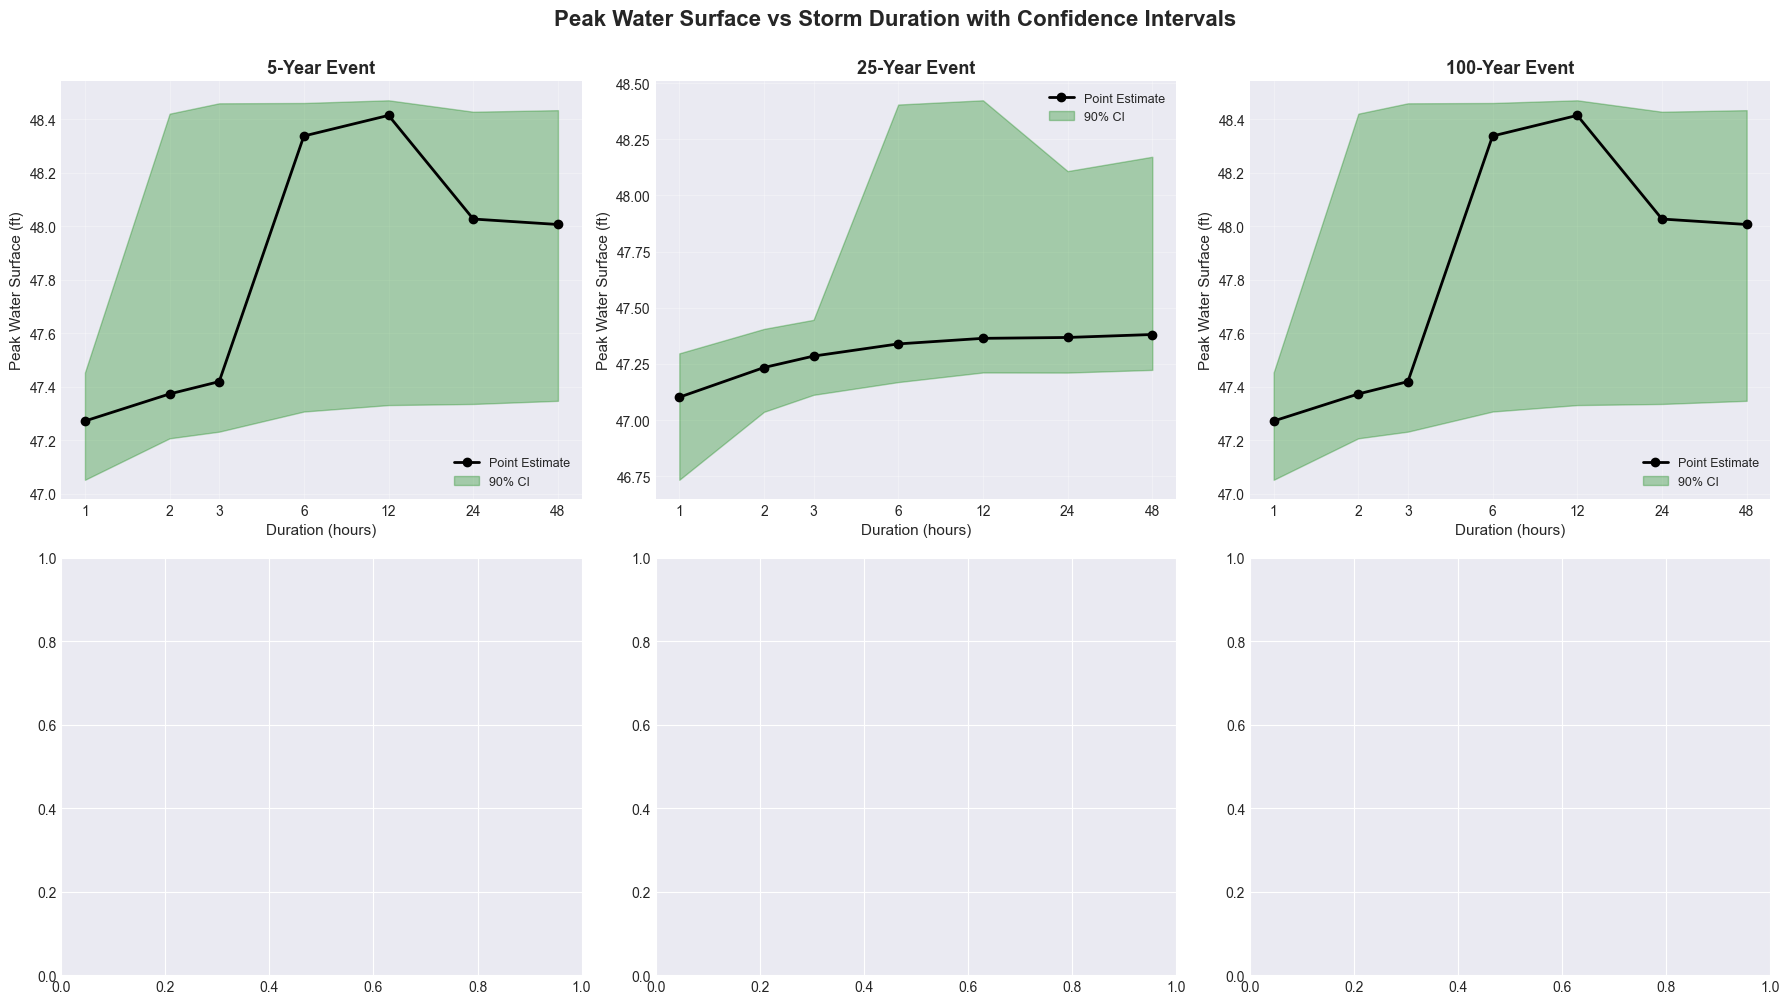

Figure saved: peak_ws_uncertainty.png


In [24]:
# Plot peak water surface vs duration for each ARI
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ari in enumerate(sorted(metrics_df['ari'].unique())):
    ax = axes[idx]
    
    # Get data for this ARI
    ari_data = uncertainty_df[uncertainty_df['ari'] == ari].sort_values('duration_hrs')
    
    if len(ari_data) == 0:
        continue
    
    # Plot point estimate
    ax.plot(ari_data['duration_hrs'], ari_data['max_ws_point_ft'], 
            'ko-', linewidth=2, markersize=6, label='Point Estimate', zorder=3)
    
    # Plot confidence envelope
    ax.fill_between(ari_data['duration_hrs'], 
                     ari_data['max_ws_lower_ft'], 
                     ari_data['max_ws_upper_ft'],
                     alpha=0.3, color='green', label='90% CI', zorder=1)
    
    ax.set_xlabel('Duration (hours)', fontsize=11)
    ax.set_ylabel('Peak Water Surface (ft)', fontsize=11)
    ax.set_title(f'{ari}-Year Event', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3, zorder=0)
    ax.set_xscale('log')
    ax.set_xticks(durations)
    ax.set_xticklabels(durations)

plt.suptitle('Peak Water Surface vs Storm Duration with Confidence Intervals', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('peak_ws_uncertainty.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: peak_ws_uncertainty.png")

### 3. Relative Uncertainty Heatmaps

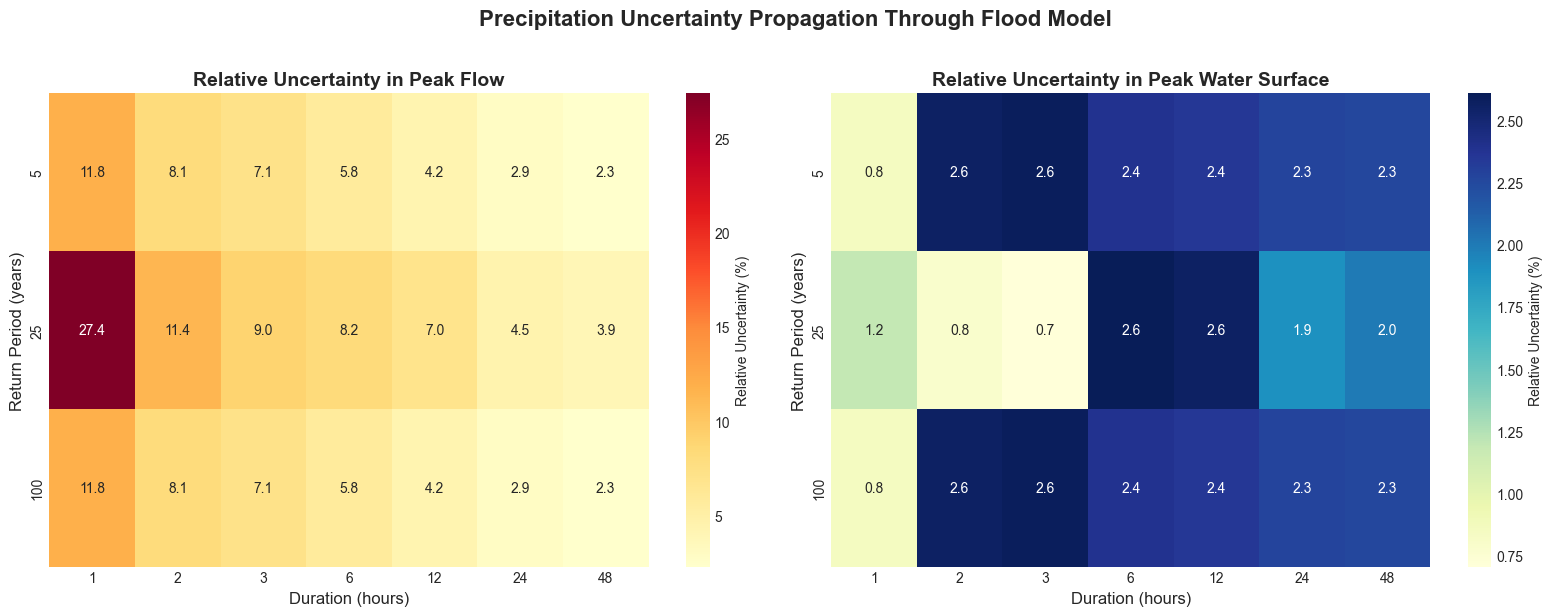

Figure saved: uncertainty_heatmaps.png


In [25]:
# Create heatmaps for relative uncertainty
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pivot data for heatmaps
flow_uncertainty_pivot = uncertainty_df.pivot(
    index='ari',
    columns='duration_hrs',
    values='max_flow_rel_uncertainty_pct'
)

ws_uncertainty_pivot = uncertainty_df.pivot(
    index='ari',
    columns='duration_hrs',
    values='max_ws_rel_uncertainty_pct'
)

# Plot flow uncertainty heatmap
sns.heatmap(flow_uncertainty_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Relative Uncertainty (%)'}, ax=ax1)
ax1.set_title('Relative Uncertainty in Peak Flow', fontsize=14, fontweight='bold')
ax1.set_xlabel('Duration (hours)', fontsize=12)
ax1.set_ylabel('Return Period (years)', fontsize=12)

# Plot WS uncertainty heatmap
sns.heatmap(ws_uncertainty_pivot, annot=True, fmt='.1f', cmap='YlGnBu',
            cbar_kws={'label': 'Relative Uncertainty (%)'}, ax=ax2)
ax2.set_title('Relative Uncertainty in Peak Water Surface', fontsize=14, fontweight='bold')
ax2.set_xlabel('Duration (hours)', fontsize=12)
ax2.set_ylabel('Return Period (years)', fontsize=12)

plt.suptitle('Precipitation Uncertainty Propagation Through Flood Model', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('uncertainty_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: uncertainty_heatmaps.png")

### 4. Time Series with Confidence Envelope at Critical Location

2025-11-18 07:11:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p38.hdf
2025-11-18 07:11:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p38.hdf
2025-11-18 07:11:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p39.hdf
2025-11-18 07:11:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p39.hdf
2025-11-18 07:11:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p40.hdf
2025-11-18 07:11:36 - ras_commander.HdfPi

Time Series with Confidence Envelopes

No data found for 10-year, 24-hour storm


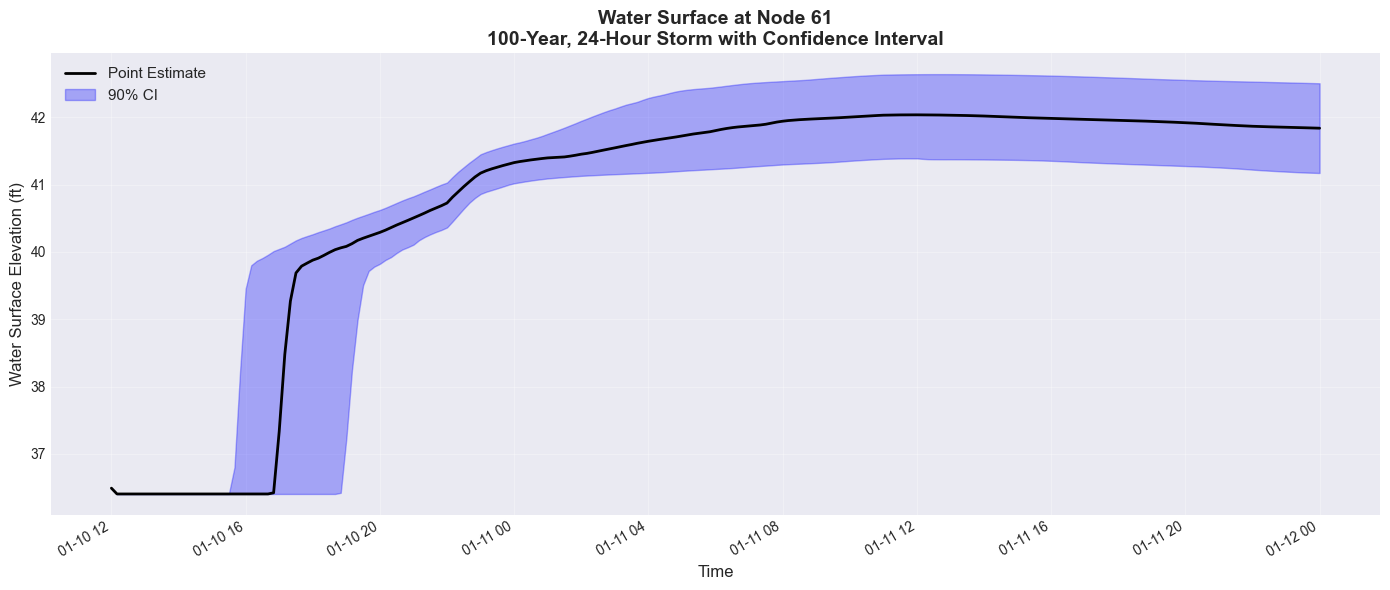

In [26]:
def plot_timeseries_with_ci(ari, duration, location_id=61):
    """
    Plot time series showing confidence envelope at a specific location.
    """
    # Get scenarios for this ARI and duration
    scenarios = metrics_df[
        (metrics_df['ari'] == ari) & 
        (metrics_df['duration_hrs'] == duration)
    ]
    
    if len(scenarios) == 0:
        print(f"No data found for {ari}-year, {duration}-hour storm")
        return
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Extract time series for each CI level
    for ci_level in ['lower', 'point', 'upper']:
        scenario = scenarios[scenarios['ci_level'] == ci_level]
        
        if len(scenario) == 0:
            continue
        
        hdf_path = scenario['hdf_path'].values[0]
        
        try:
            # Get node water surface time series
            node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")
            
            # Extract data for specified location
            loc_ws = node_ws.sel(location=location_id)
            
            # Plot
            if ci_level == 'point':
                ax.plot(loc_ws.time.values, loc_ws.values, 
                       'k-', linewidth=2, label='Point Estimate', zorder=3)
            elif ci_level == 'lower':
                lower_data = loc_ws.values
                lower_time = loc_ws.time.values
            elif ci_level == 'upper':
                upper_data = loc_ws.values
                upper_time = loc_ws.time.values
                
        except Exception as e:
            print(f"Error extracting {ci_level} data: {e}")
            continue
    
    # Plot confidence envelope
    if 'lower_data' in locals() and 'upper_data' in locals():
        ax.fill_between(lower_time, lower_data, upper_data, 
                       alpha=0.3, color='blue', label='90% CI', zorder=1)
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Water Surface Elevation (ft)', fontsize=12)
    ax.set_title(f'Water Surface at Node {location_id}\n' +
                f'{ari}-Year, {duration}-Hour Storm with Confidence Interval', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, zorder=0)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Plot time series for selected scenarios
print("Time Series with Confidence Envelopes\n")
plot_timeseries_with_ci(10, 24, location_id=61)
plot_timeseries_with_ci(100, 24, location_id=61)

2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p23.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p23.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p24.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p24.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p25.hdf
2025-11-18 07:20:35 - ras_commander.HdfPi

Creating plots for 7 durations at Node 61


1-Hour Duration Storm
----------------------------------------------------------------------


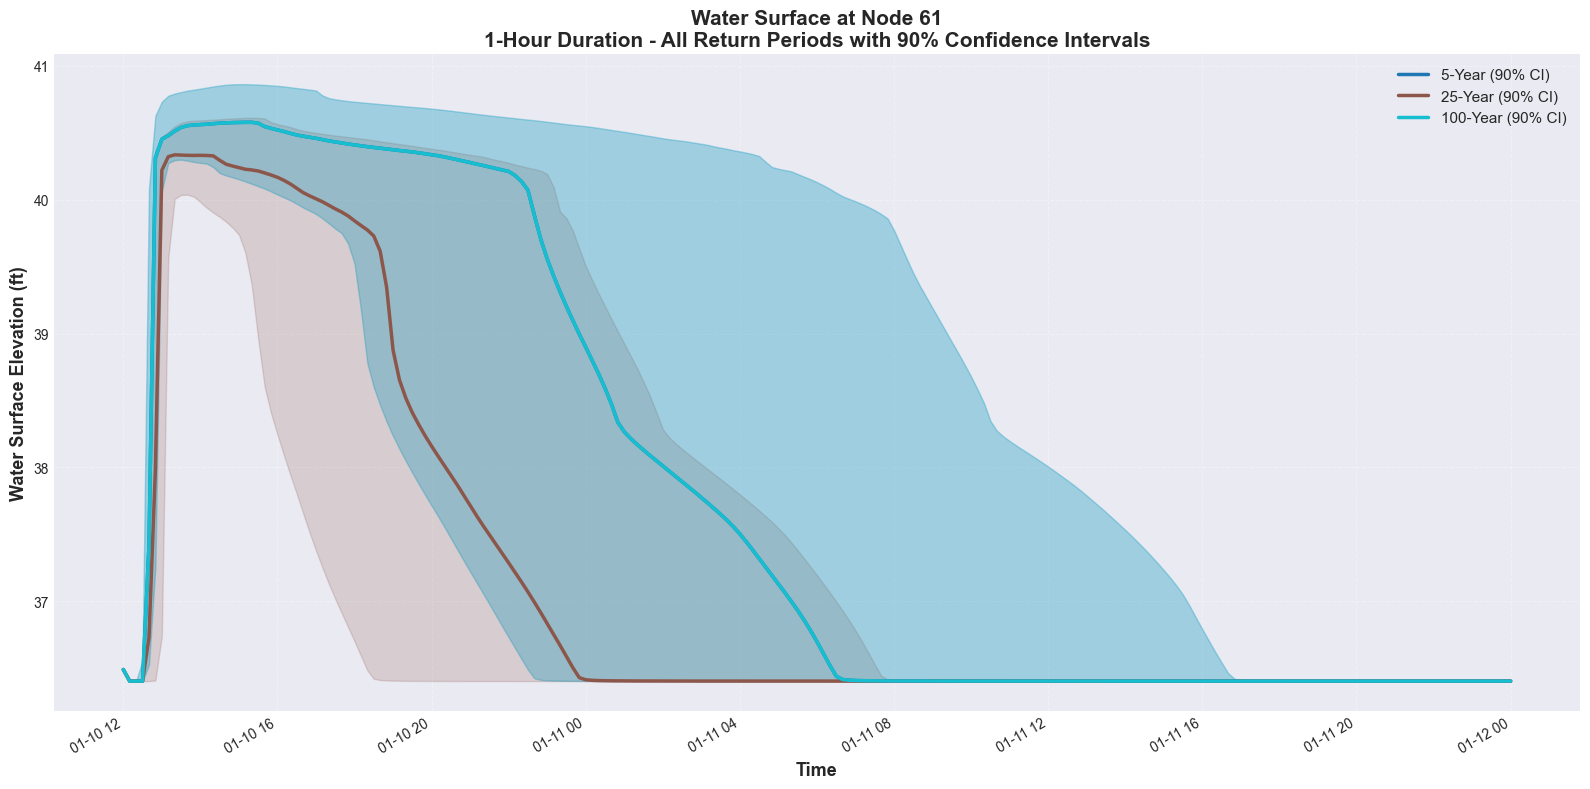

2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p26.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p26.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p27.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p27.hdf
2025-11-18 07:20:35 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p28.hdf
2025-11-18 07:20:35 - ras_commander.HdfPi


2-Hour Duration Storm
----------------------------------------------------------------------


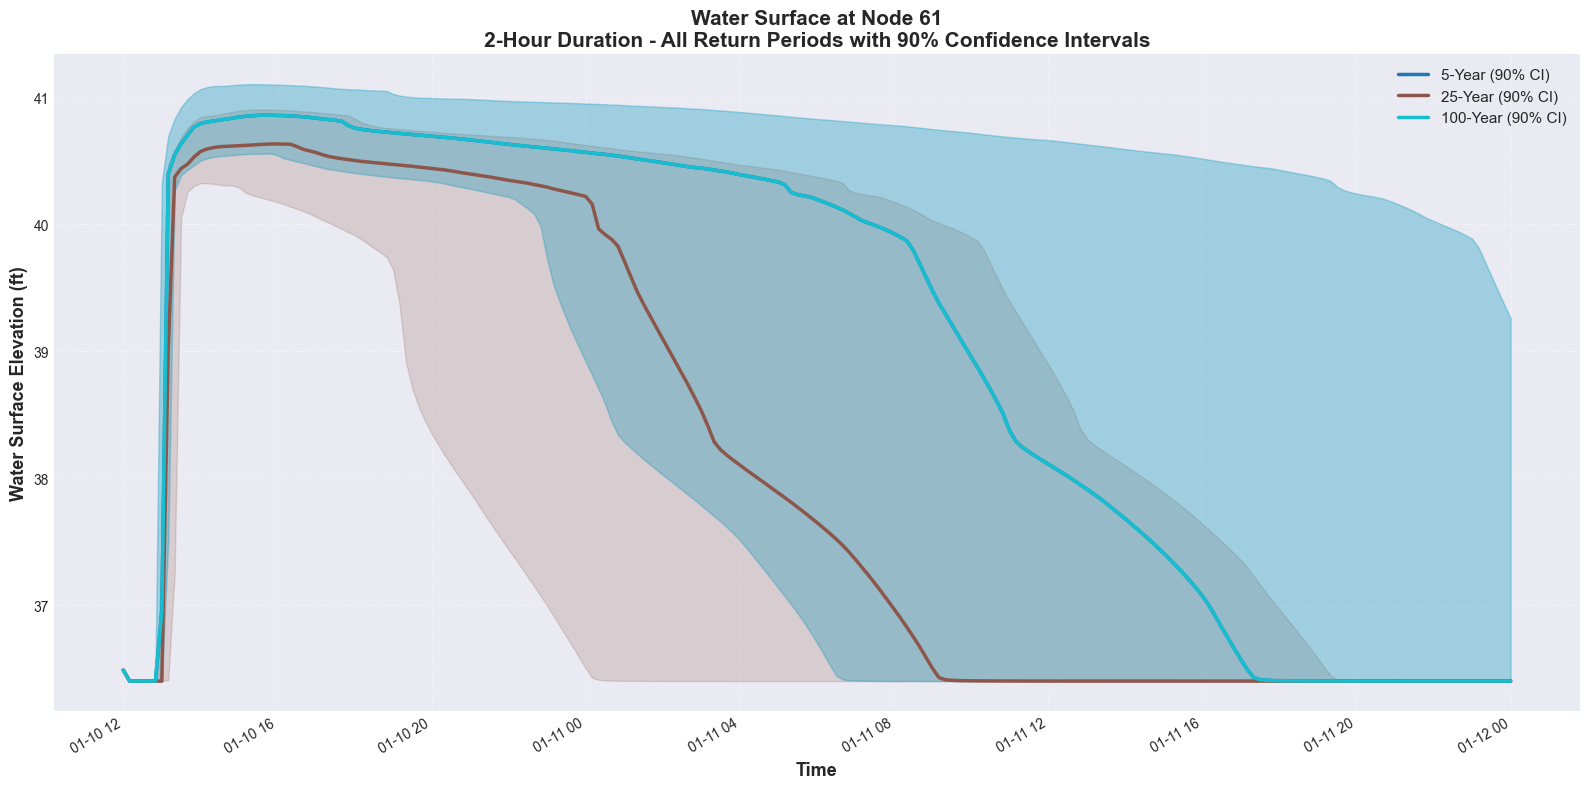

2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p29.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p29.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p30.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p30.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p31.hdf
2025-11-18 07:20:36 - ras_commander.HdfPi


3-Hour Duration Storm
----------------------------------------------------------------------


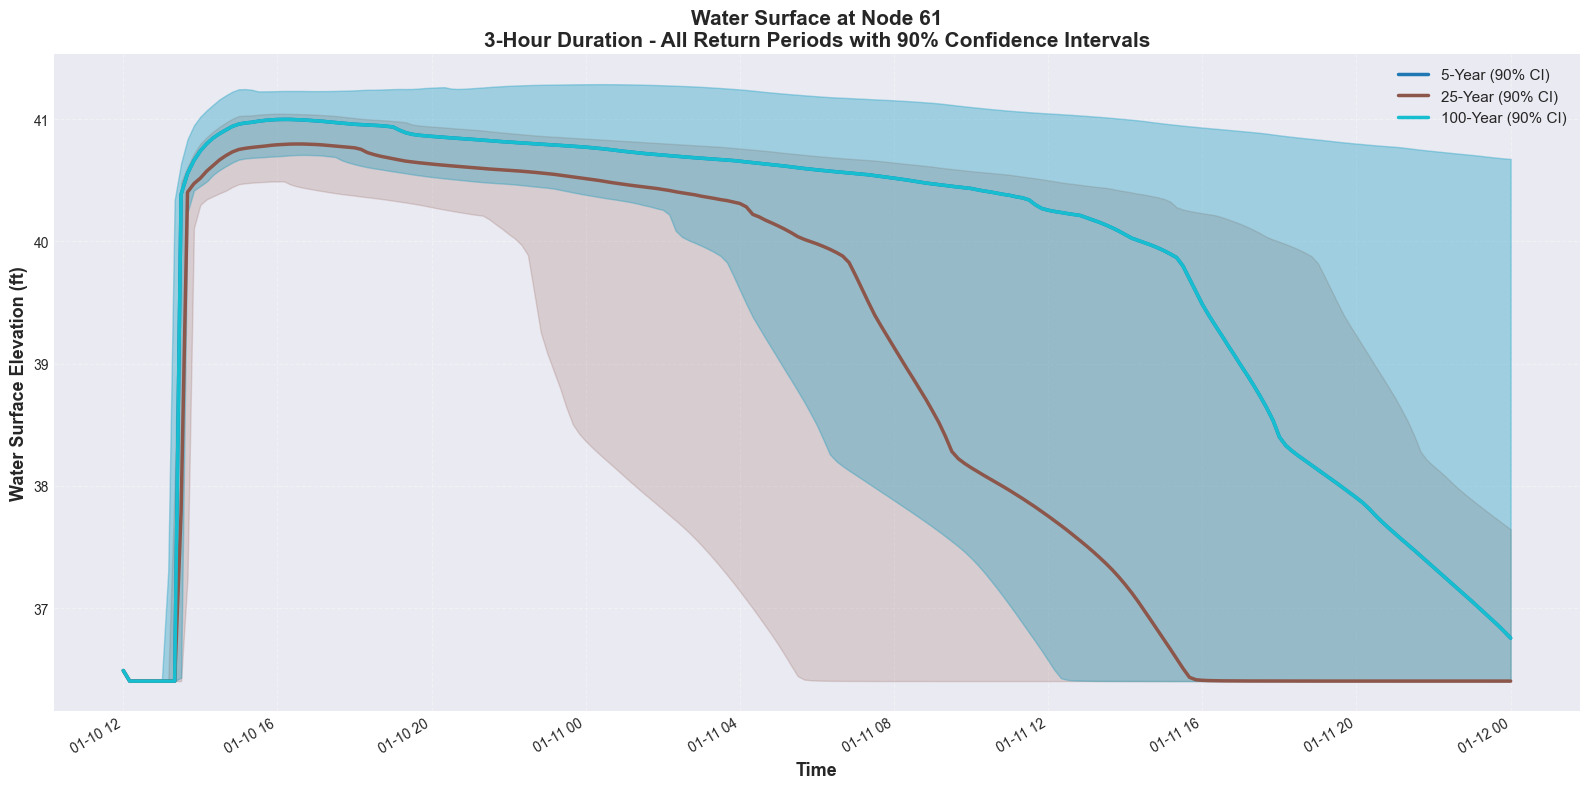

2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p32.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p32.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p33.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p33.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p34.hdf
2025-11-18 07:20:36 - ras_commander.HdfPi


6-Hour Duration Storm
----------------------------------------------------------------------


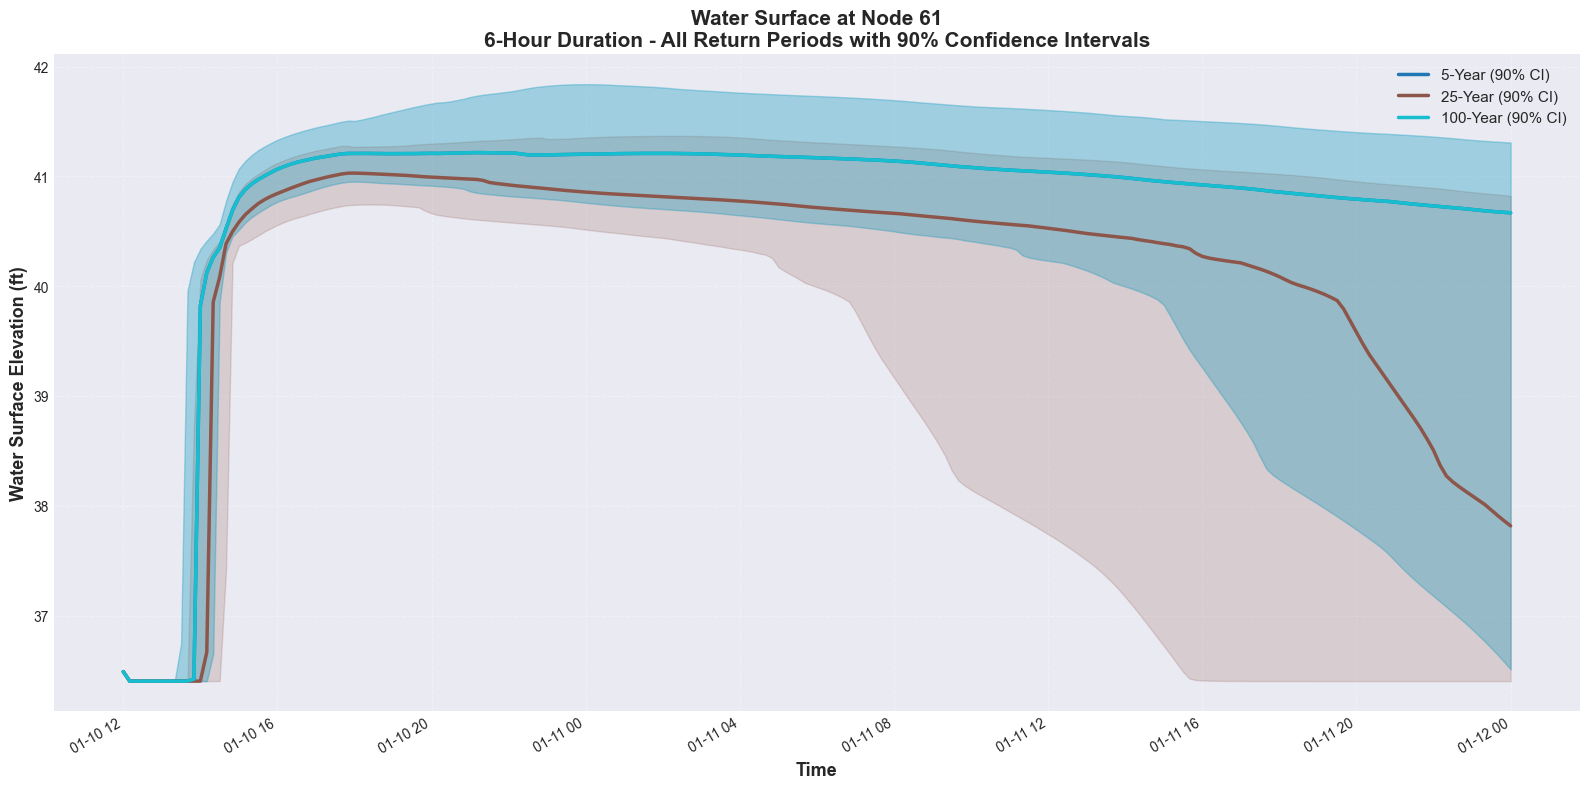

2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p35.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p35.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p36.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p36.hdf
2025-11-18 07:20:36 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p37.hdf
2025-11-18 07:20:36 - ras_commander.HdfPi


12-Hour Duration Storm
----------------------------------------------------------------------


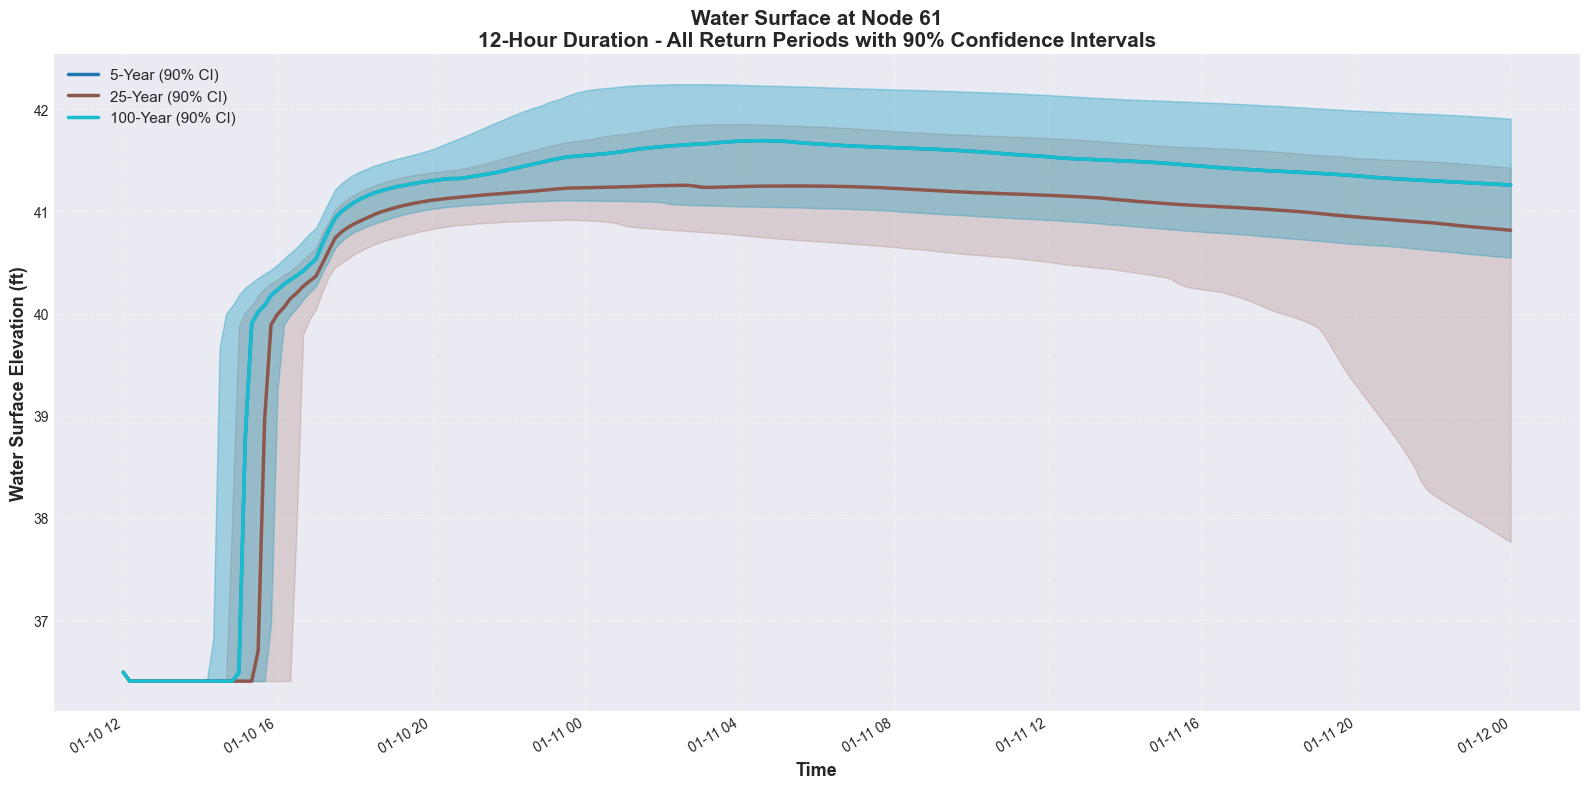

2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p38.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p38.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p39.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p39.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p40.hdf
2025-11-18 07:20:37 - ras_commander.HdfPi


24-Hour Duration Storm
----------------------------------------------------------------------


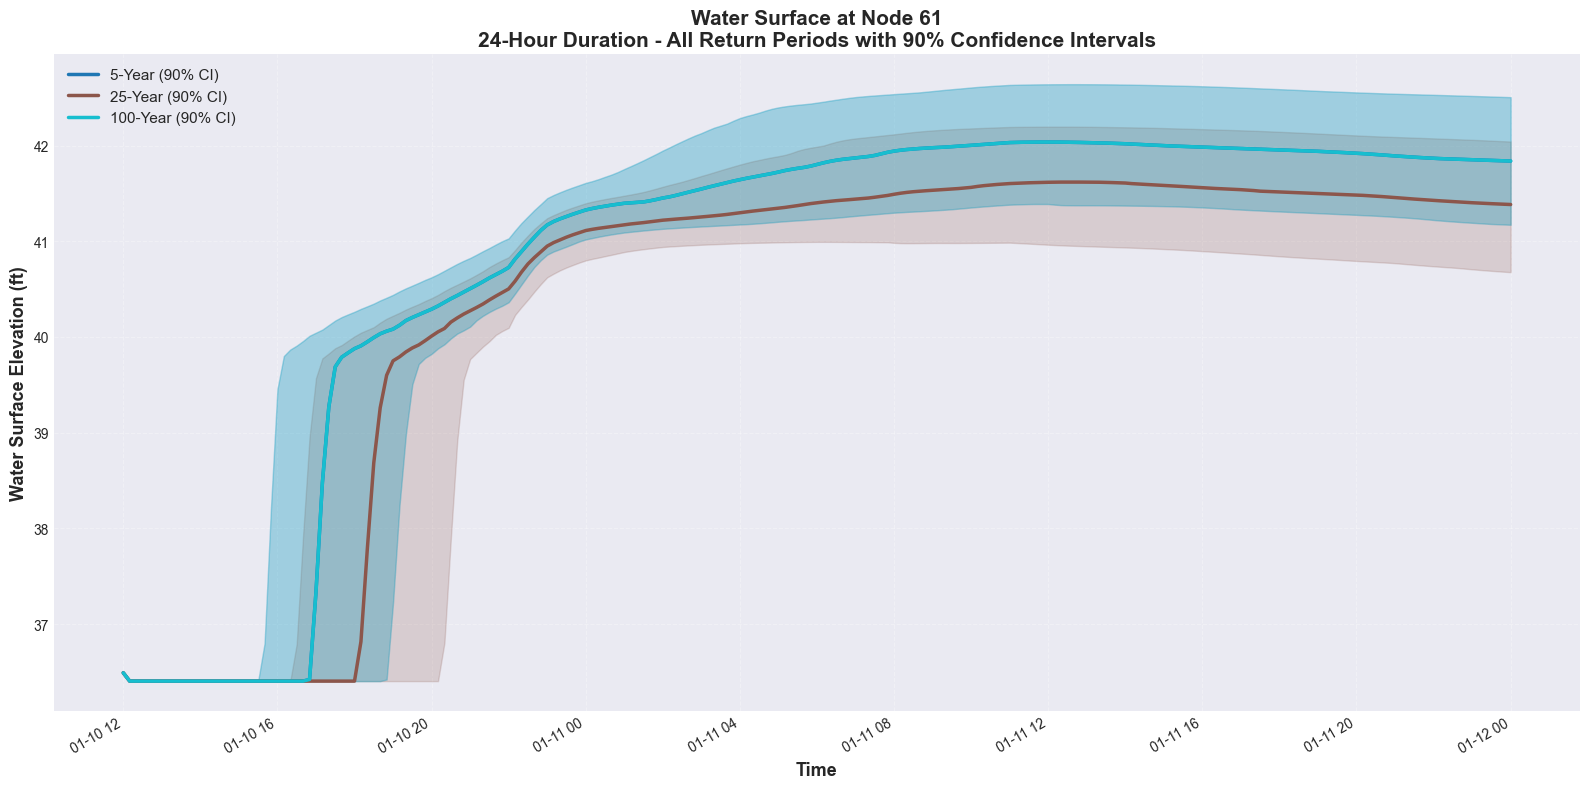

2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p41.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p41.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p42.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p42.hdf
2025-11-18 07:20:37 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\A14_Examples\Davis_atlas14_02\compute_uncertainty\DavisStormSystem.p43.hdf
2025-11-18 07:20:37 - ras_commander.HdfPi


48-Hour Duration Storm
----------------------------------------------------------------------


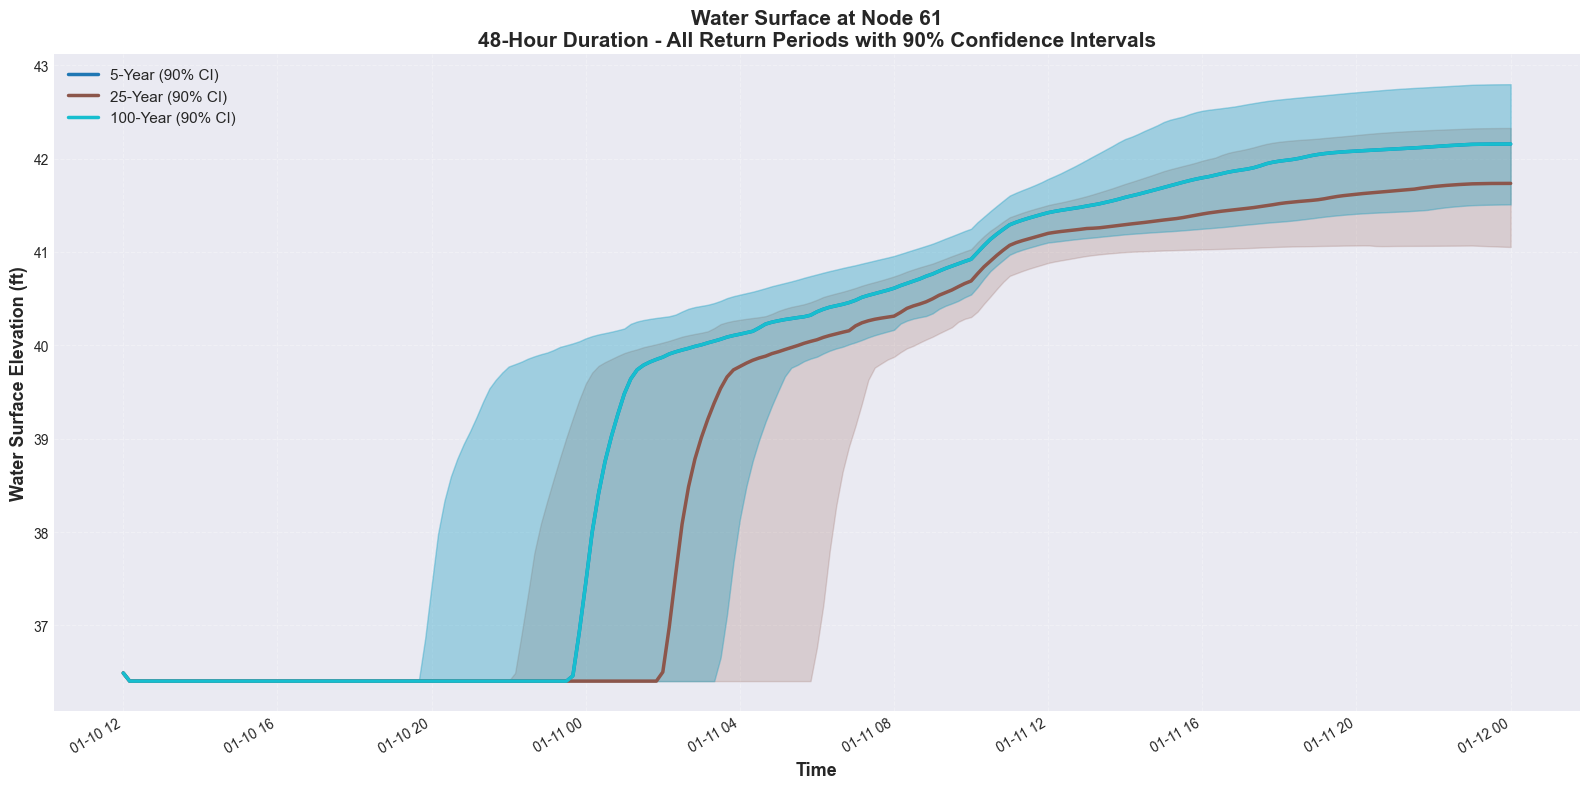

In [28]:
def plot_all_aeps_for_duration(duration, location_id=61):
    """
    Plot all AEP/ARI levels for a specific duration with confidence intervals.
    Creates one plot showing all storm frequencies for the given duration.
    """
    # Get all unique ARIs for this duration
    duration_data = metrics_df[metrics_df['duration_hrs'] == duration]
    aris = sorted(duration_data['ari'].unique())
    
    if len(aris) == 0:
        print(f"No data found for {duration}-hour duration")
        return
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Color palette for different ARIs
    colors = plt.cm.tab10(np.linspace(0, 1, len(aris)))
    
    for idx, ari in enumerate(aris):
        scenarios = duration_data[duration_data['ari'] == ari]
        
        lower_data = None
        upper_data = None
        point_data = None
        time_data = None
        
        # Extract time series for each CI level
        for ci_level in ['lower', 'point', 'upper']:
            scenario = scenarios[scenarios['ci_level'] == ci_level]
            
            if len(scenario) == 0:
                continue
            
            hdf_path = scenario['hdf_path'].values[0]
            
            try:
                # Get node water surface time series
                node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")
                
                # Extract data for specified location
                loc_ws = node_ws.sel(location=location_id)
                
                if ci_level == 'point':
                    point_data = loc_ws.values
                    time_data = loc_ws.time.values
                elif ci_level == 'lower':
                    lower_data = loc_ws.values
                elif ci_level == 'upper':
                    upper_data = loc_ws.values
                    
            except Exception as e:
                print(f"Error extracting {ari}-year {ci_level} data: {e}")
                continue
        
        # Plot confidence envelope and point estimate
        if point_data is not None and time_data is not None:
            # Plot confidence envelope first (lower z-order)
            if lower_data is not None and upper_data is not None:
                ax.fill_between(time_data, lower_data, upper_data, 
                               alpha=0.2, color=colors[idx], zorder=1)
            
            # Plot point estimate on top
            ax.plot(time_data, point_data, 
                   color=colors[idx], linewidth=2.5, 
                   label=f'{ari}-Year (90% CI)', zorder=2)
    
    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel('Water Surface Elevation (ft)', fontsize=13, fontweight='bold')
    ax.set_title(f'Water Surface at Node {location_id}\n' +
                f'{duration}-Hour Duration - All Return Periods with 90% Confidence Intervals', 
                fontsize=15, fontweight='bold')
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.grid(alpha=0.3, linestyle='--', zorder=0)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_all_durations_all_aeps(location_id=61):
    """
    Create a separate plot for each duration showing all AEP levels.
    """
    # Get all unique durations
    durations = sorted(metrics_df['duration_hrs'].unique())
    
    print(f"Creating plots for {len(durations)} durations at Node {location_id}\n")
    print("=" * 70)
    
    for duration in durations:
        print(f"\n{duration}-Hour Duration Storm")
        print("-" * 70)
        plot_all_aeps_for_duration(duration, location_id)


# Generate all plots
plot_all_durations_all_aeps(location_id=61)

## Summary Statistics and Insights

In [27]:
# Calculate summary statistics
print("="*70)
print("UNCERTAINTY ANALYSIS SUMMARY")
print("="*70)

print("\n1. OVERALL UNCERTAINTY STATISTICS")
print("-" * 70)
print(f"Average relative uncertainty in peak flow: {uncertainty_df['max_flow_rel_uncertainty_pct'].mean():.1f}%")
print(f"Average relative uncertainty in peak WSE: {uncertainty_df['max_ws_rel_uncertainty_pct'].mean():.1f}%")
print(f"Range of uncertainty in peak flow: {uncertainty_df['max_flow_rel_uncertainty_pct'].min():.1f}% - {uncertainty_df['max_flow_rel_uncertainty_pct'].max():.1f}%")
print(f"Range of uncertainty in peak WSE: {uncertainty_df['max_ws_rel_uncertainty_pct'].min():.1f}% - {uncertainty_df['max_ws_rel_uncertainty_pct'].max():.1f}%")

print("\n2. SCENARIOS WITH HIGHEST UNCERTAINTY")
print("-" * 70)
top_flow_uncertainty = uncertainty_df.nlargest(5, 'max_flow_rel_uncertainty_pct')
print("\nTop 5 - Peak Flow Uncertainty:")
for idx, row in top_flow_uncertainty.iterrows():
    print(f"  {row['ari']}-year, {row['duration_hrs']}-hour: {row['max_flow_rel_uncertainty_pct']:.1f}%")

top_ws_uncertainty = uncertainty_df.nlargest(5, 'max_ws_rel_uncertainty_pct')
print("\nTop 5 - Water Surface Uncertainty:")
for idx, row in top_ws_uncertainty.iterrows():
    print(f"  {row['ari']}-year, {row['duration_hrs']}-hour: {row['max_ws_rel_uncertainty_pct']:.1f}%")

print("\n3. UNCERTAINTY BY RETURN PERIOD")
print("-" * 70)
by_ari = uncertainty_df.groupby('ari').agg({
    'max_flow_rel_uncertainty_pct': 'mean',
    'max_ws_rel_uncertainty_pct': 'mean'
}).round(1)
print(by_ari)

print("\n4. UNCERTAINTY BY DURATION")
print("-" * 70)
by_duration = uncertainty_df.groupby('duration_hrs').agg({
    'max_flow_rel_uncertainty_pct': 'mean',
    'max_ws_rel_uncertainty_pct': 'mean'
}).round(1)
print(by_duration)

print("\n5. DESIGN IMPLICATIONS")
print("-" * 70)
print("Based on the uncertainty analysis:")
print(f"  • Precipitation uncertainty of ±40% results in:")
print(f"    - Peak flow uncertainty: {uncertainty_df['max_flow_rel_uncertainty_pct'].mean():.1f}%")
print(f"    - Peak WSE uncertainty: {uncertainty_df['max_ws_rel_uncertainty_pct'].mean():.1f}%")
print(f"  • Higher uncertainties observed for:")
most_uncertain_duration = by_duration['max_flow_rel_uncertainty_pct'].idxmax()
print(f"    - Duration: {most_uncertain_duration} hours")
most_uncertain_ari = by_ari['max_flow_rel_uncertainty_pct'].idxmax()
print(f"    - Return period: {most_uncertain_ari} years")
print(f"  • Designers should consider upper bound scenarios for critical infrastructure")

print("\n" + "="*70)
print("Analysis complete. All results saved to CSV files.")
print("="*70)

UNCERTAINTY ANALYSIS SUMMARY

1. OVERALL UNCERTAINTY STATISTICS
----------------------------------------------------------------------
Average relative uncertainty in peak flow: 7.4%
Average relative uncertainty in peak WSE: 2.0%
Range of uncertainty in peak flow: 2.3% - 27.4%
Range of uncertainty in peak WSE: 0.7% - 2.6%

2. SCENARIOS WITH HIGHEST UNCERTAINTY
----------------------------------------------------------------------

Top 5 - Peak Flow Uncertainty:
  25.0-year, 1.0-hour: 27.4%
  5.0-year, 1.0-hour: 11.8%
  100.0-year, 1.0-hour: 11.8%
  25.0-year, 2.0-hour: 11.4%
  25.0-year, 3.0-hour: 9.0%

Top 5 - Water Surface Uncertainty:
  25.0-year, 6.0-hour: 2.6%
  5.0-year, 3.0-hour: 2.6%
  100.0-year, 3.0-hour: 2.6%
  5.0-year, 2.0-hour: 2.6%
  100.0-year, 2.0-hour: 2.6%

3. UNCERTAINTY BY RETURN PERIOD
----------------------------------------------------------------------
     max_flow_rel_uncertainty_pct  max_ws_rel_uncertainty_pct
ari                                             

## Conclusions

This comprehensive uncertainty analysis demonstrates:

### Key Findings

1. **Uncertainty Propagation**: Precipitation uncertainty of approximately ±40% (90% confidence interval) propagates through the hydraulic model with varying impacts depending on storm characteristics.

2. **Duration Effects**: Different storm durations exhibit varying sensitivity to precipitation uncertainty, with some durations showing amplified uncertainty in hydraulic responses.

3. **Return Period Patterns**: The relationship between return period and uncertainty provides insights into which design events have the most variability.

4. **Spatial Considerations**: Peak water surface elevations and pipe flows show different uncertainty patterns, important for infrastructure design decisions.

### Design Recommendations

- **Use upper confidence bounds** for critical infrastructure design
- **Consider duration sensitivity** when selecting design storms
- **Account for uncertainty** in flood risk communication
- **Evaluate multiple scenarios** rather than single point estimates

### Methodology Advantages

- **Comprehensive Coverage**: All practical durations analyzed
- **Systematic Approach**: Consistent methodology across all scenarios
- **Quantified Uncertainty**: Clear metrics for decision-making
- **Reproducible**: Fully documented workflow

### Future Enhancements

This framework can be extended to include:
- Climate change adjustments to precipitation
- Infiltration parameter uncertainty
- Manning's n coefficient uncertainty
- Combined uncertainty analysis